In [179]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy.stats import ttest_ind, shapiro, mannwhitneyu, probplot, levene
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [41]:
df_features = pd.read_csv('mice_behavior_capstone/process_data/results/all_the_data.csv')

#Strings to not be considered
arms= ['CL', 'CR', 'OT', 'OB', 'M', 'F1', 'F2', 'F3', 'F4', 'bottom', 'count', '_num_']

In [42]:
#Considers only these features
cols_main= [col for col in df_features.columns if not any(arm in col for arm in arms)]
# cols_main_final = [e for e in cols_main if e not in ('Unnamed: 0', 'inner_directory', 'mouse_details_date', 'mouse_details_mouseID',
#                                               'mouse_details_time',)]

In [5]:
# final_features= [col for col in df_features_final.columns if col not in ('mouse_details_sex', 'mouse_details_strain')]

In [287]:
# In velocity, only active speed considered as closed speed influenced by another features: fraction rest!

final_features= ['fraction_in_arms_closed', 'fraction_in_arms_middle', 'fraction_in_arms_open',
               'mouse_length',
               'peeking_average_length_total', 'peeking_fraction_total', 'peeking_median_length_total',
               'rest_fraction_all_arms', 'rest_fraction_closed_arms', 'rest_fraction_open_arms',
               'safety_and_rest_fraction_closed_arms', 'safety_fraction_closed_arms',
#  'total_distance_closed',
#  'total_distance_open',
               'turning_preferences_fraction_back', 'turning_preferences_fraction_left', 
               'turning_preferences_fraction_right', 'turning_preferences_fraction_straight',
#  'turning_preferences_fraction_back_into_closed',
#  'turning_preferences_fraction_back_into_open',
#  'turning_preferences_fraction_back_only_straight_back',
#  'turning_preferences_fraction_back_only_straight_back_into_closed',
#  'turning_preferences_fraction_back_only_straight_back_into_open',
#  'turning_preferences_fraction_left_into_closed',
#  'turning_preferences_fraction_left_into_open',
#  'turning_preferences_fraction_left_only_right_left',
#  'turning_preferences_fraction_left_only_right_left_into_closed',
#  'turning_preferences_fraction_left_only_right_left_into_open',
#  'turning_preferences_fraction_right_into_closed',
#  'turning_preferences_fraction_right_into_open',
#  'turning_preferences_fraction_right_only_right_left',
#  'turning_preferences_fraction_right_only_right_left_into_closed',
#  'turning_preferences_fraction_right_only_right_left_into_open',
#  'turning_preferences_fraction_straight_into_closed',
#  'turning_preferences_fraction_straight_into_open',
#  'turning_preferences_fraction_straight_only_straight_back',
#  'turning_preferences_fraction_straight_only_straight_back_into_closed',
#  'turning_preferences_fraction_straight_only_straight_back_into_open',
# 'velocity_closed_towards_middle_average_speed',
 'velocity_closed_towards_middle_average_speed_active',
#  'velocity_closed_towards_middle_median_speed',
 'velocity_closed_towards_middle_median_speed_active',
#  'velocity_closed_towards_outside_average_speed',
 'velocity_closed_towards_outside_average_speed_active',
#  'velocity_closed_towards_outside_median_speed',
 'velocity_closed_towards_outside_median_speed_active',
#  'velocity_open_towards_middle_average_speed',
 'velocity_open_towards_middle_average_speed_active',
#  'velocity_open_towards_middle_median_speed',
 'velocity_open_towards_middle_median_speed_active',
#  'velocity_open_towards_outside_average_speed',
 'velocity_open_towards_outside_average_speed_active',
#  'velocity_open_towards_outside_median_speed',
 'velocity_open_towards_outside_median_speed_active']

In [219]:
df_bwpo = df_features.loc[(df_features['mouse_details_strain'].isin(['BW', 'PO'])) &
                          (df_features['mouse_details_sex'].isin(['M', 'F'])), :].dropna()

In [288]:
df_bwpo.rename(columns = {'fraction_in_arms_open-arms':'fraction_in_arms_open'}, inplace = True)

In [237]:
def one_factor_significance(df, features, alpha_normal=0.05, alpha_significance=0.05):

    ''' significance(df, features, alpha_normal=0.05, alpha_significance=0.05)
    Input: DataFrame of aggregated mice features, features, alpha levels
    Output: Normality_results, Feature significance, p-values'''
    
    #Initiate empty lists for results
    normal = [] #Boolean
    normality_p = [] #Tuple of normality test results
    stats_test_p = [] #P values
    significance = [] #Boolean, for significance
    
    for feature in features:

        strain1= df.loc[df['mouse_details_strain']=='BW', feature] 
        strain2= df.loc[df['mouse_details_strain']=='PO', feature]

        #Do a Normality test and store p value
        norm1 = shapiro(strain1)[1]
        norm2 = shapiro(strain2)[1]
        
        #If not normal, do a log transformation
        if min(norm1, norm2) < alpha_normal:
            
            #Check if log tranformation makes data more normal
            if min(shapiro(np.log(strain1))[1], shapiro(np.log(strain2))[1])> min(norm1, norm2):
                
                print(feature +" -Log done")
                strain1= np.log(strain1)
                strain2= np.log(strain2)

                norm1 = shapiro(strain1)[1]
                norm2 = shapiro(strain2)[1]
        
        normality_p.append((norm1, norm2))
        
        #Conduct a t-test if both distributions are probably sampled from a N(mu, sigma)
        if min(norm1, norm2) > alpha_normal:
            
            normal.append(True)
            
            #Do a t-test(or Anova)
            p = ttest_ind(strain1, strain2, equal_var= False)[1]
            stats_test_p.append(p)

            if p<alpha_significance: 
                significance.append(True)
            else: 
                significance.append(False)
        
        #Else, perform a non-parametric test - ideally, not performed if outliers are removed
        else:
            strain1= df.loc[df['mouse_details_strain']=='BW', feature] 
            strain2= df.loc[df['mouse_details_strain']=='PO', feature]
            
            normal.append(False)
            p = mannwhitneyu(strain1, strain2)[1]
            stats_test_p.append(p)
            
            if p<alpha_significance: 
                significance.append(True)
            else: 
                significance.append(False)

    return normal, normality_p, significance, stats_test_p

In [238]:
normal, normality_p, significance, stats_test_p= one_factor_significance(df_bwpo, features=final_features)

fraction_in_arms_open-arms -Log done
mouse_length -Log done
peeking_average_length_total -Log done
peeking_fraction_total -Log done
peeking_median_length_total -Log done
turning_preferences_fraction_left -Log done
turning_preferences_fraction_right -Log done
turning_preferences_fraction_straight -Log done
velocity_closed_towards_middle_average_speed_active -Log done
velocity_closed_towards_middle_median_speed_active -Log done
velocity_closed_towards_outside_average_speed_active -Log done
velocity_closed_towards_outside_median_speed_active -Log done
velocity_open_towards_middle_average_speed_active -Log done
velocity_open_towards_middle_median_speed_active -Log done
velocity_open_towards_outside_average_speed_active -Log done
velocity_open_towards_outside_median_speed_active -Log done


## Results

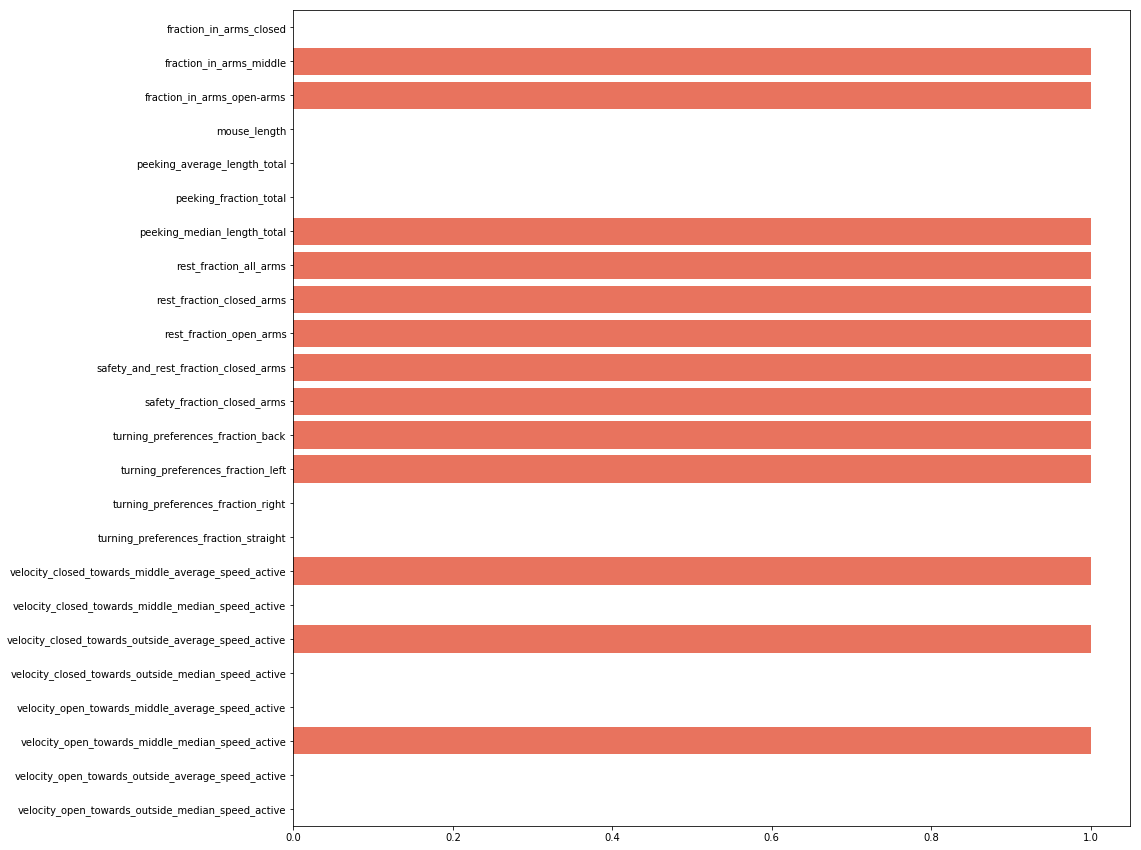

In [236]:
plt.figure(figsize=(15, 15))
sns.barplot(x= normal, y= final_features, color='tomato')
plt.title("")

plt.show()

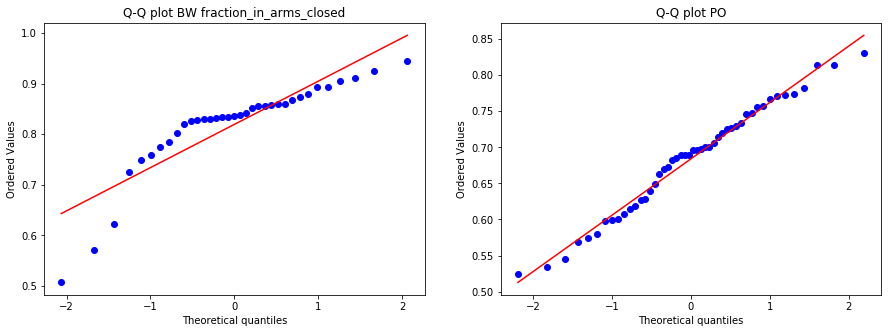

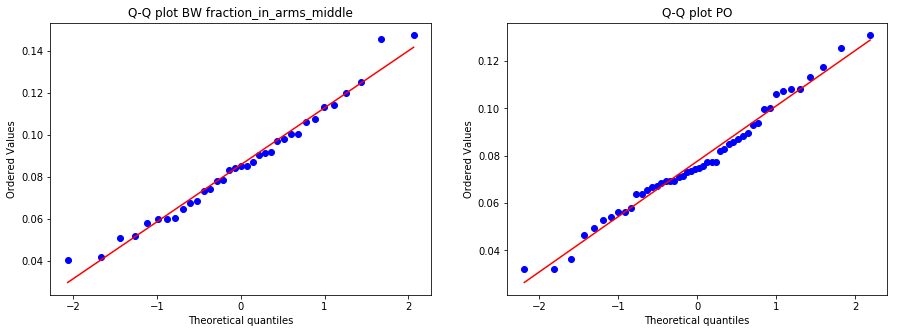

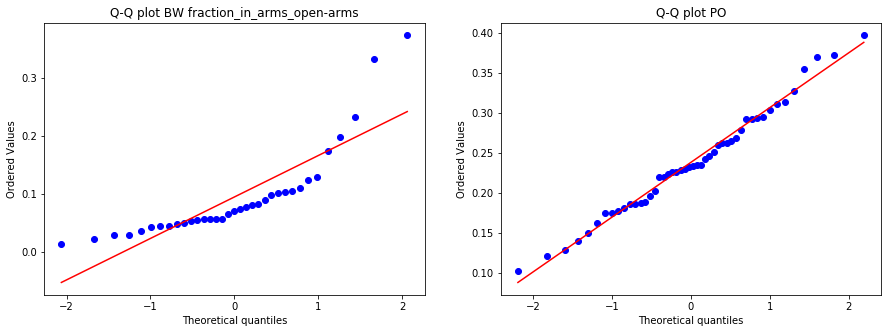

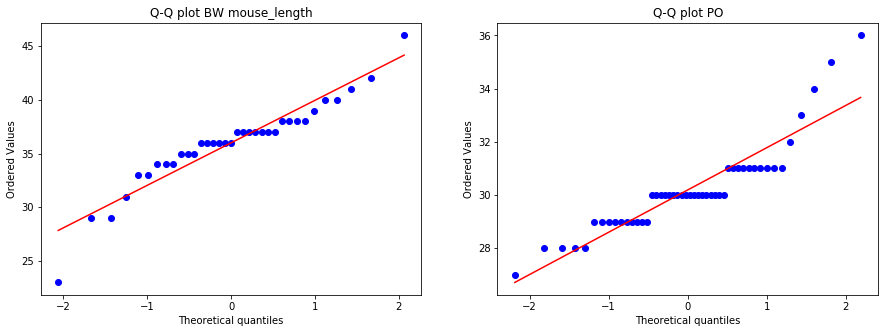

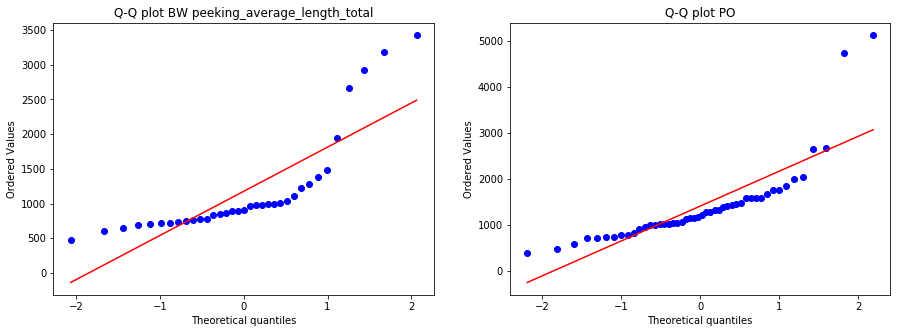

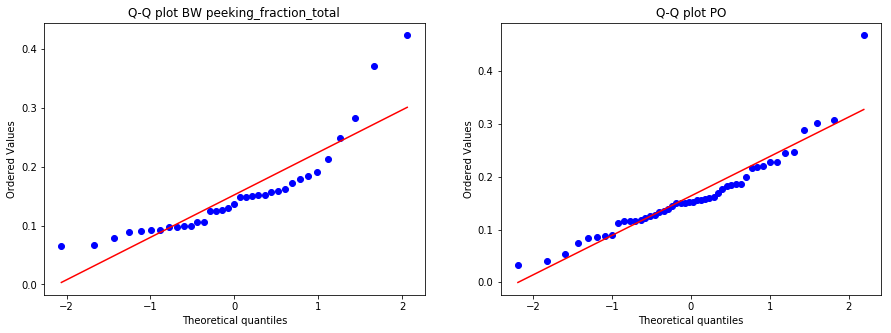

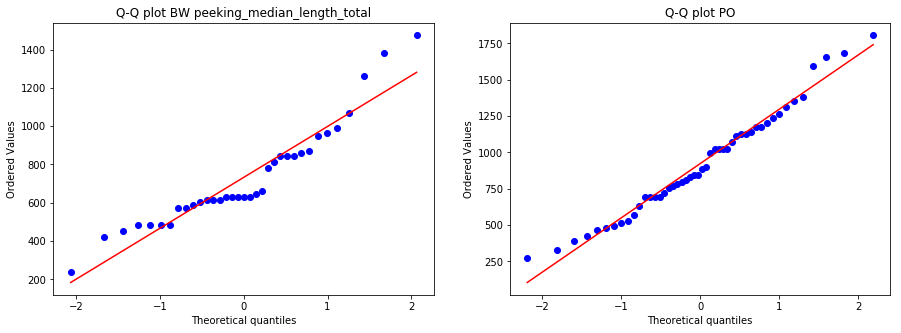

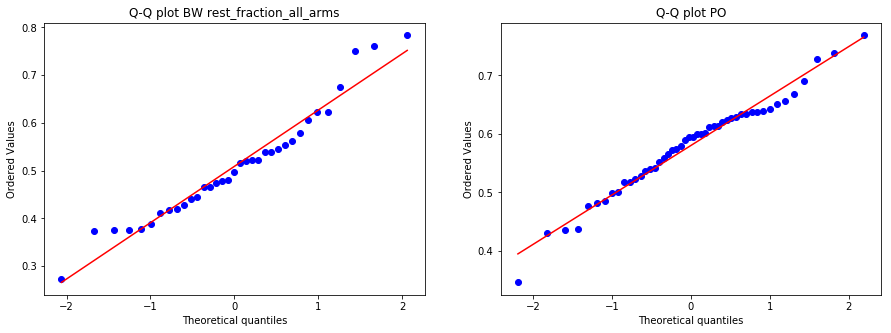

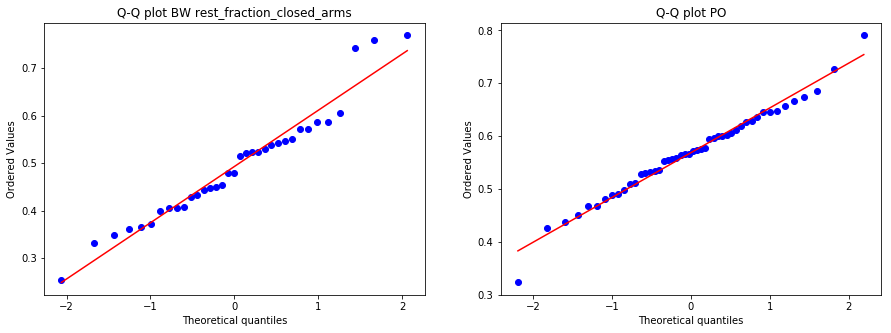

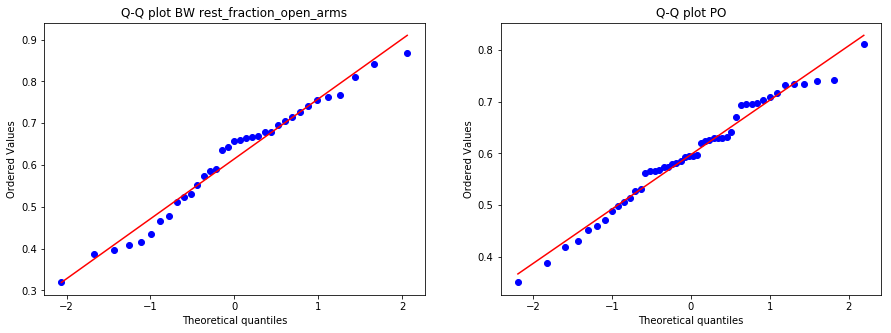

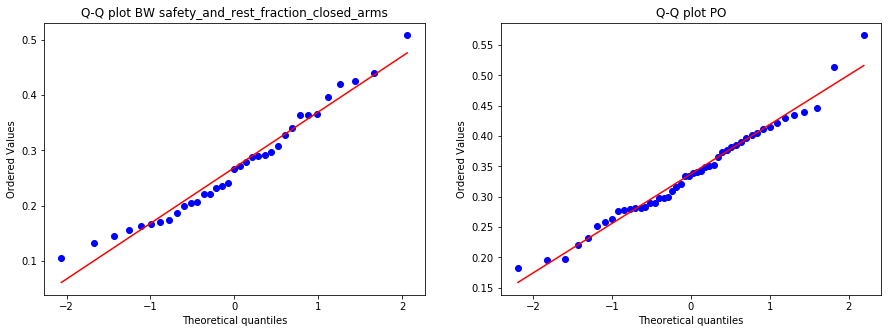

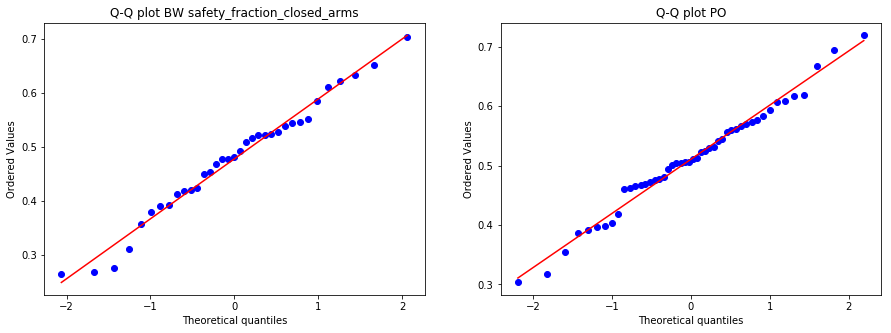

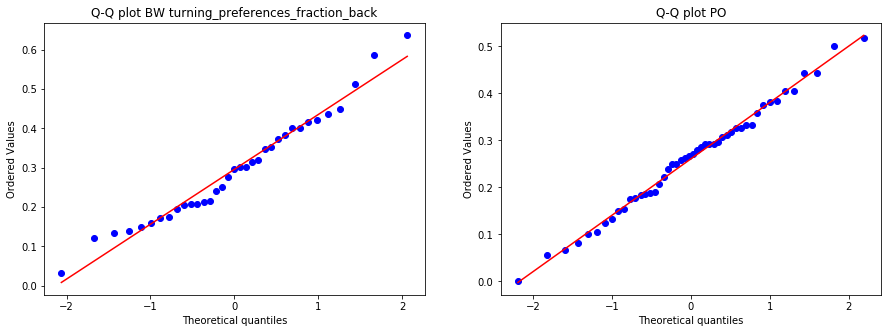

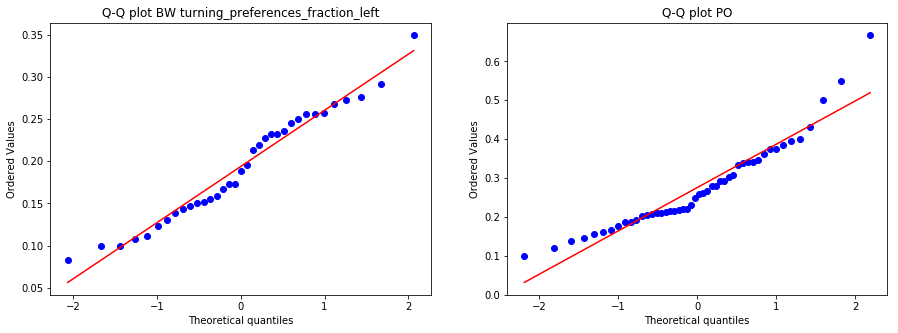

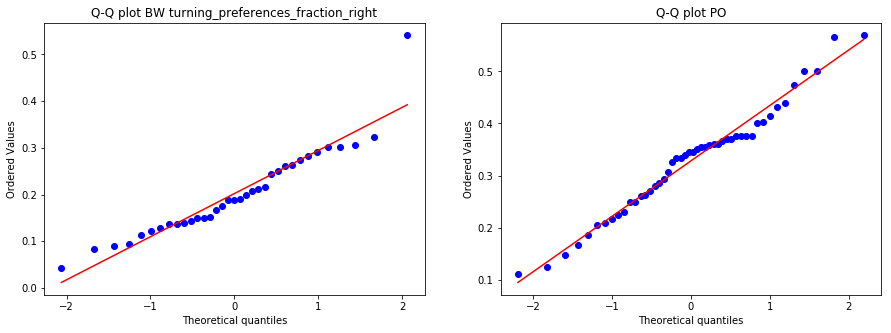

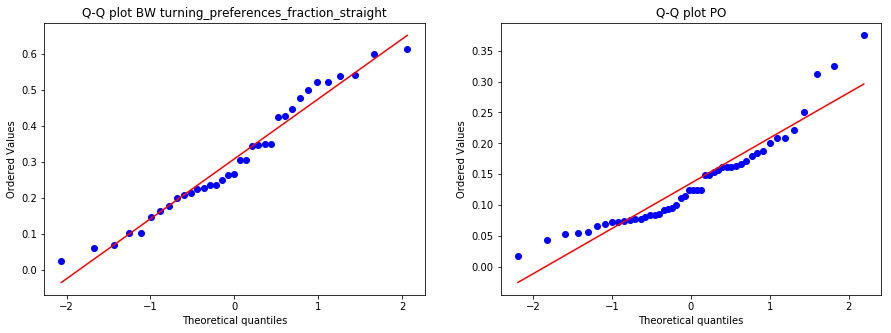

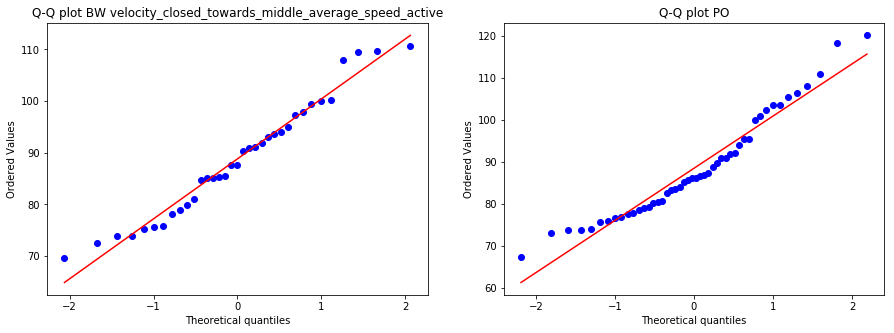

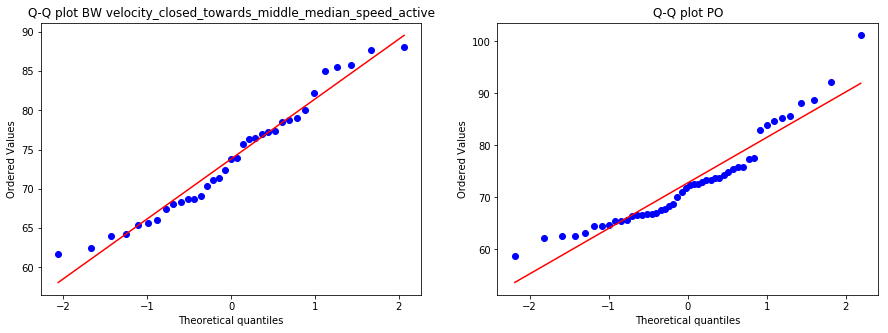

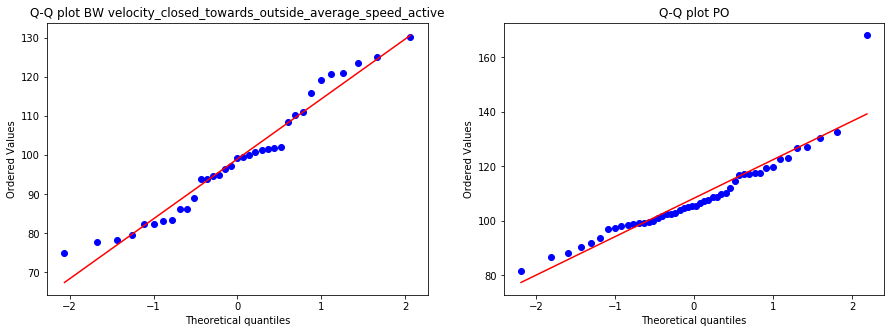

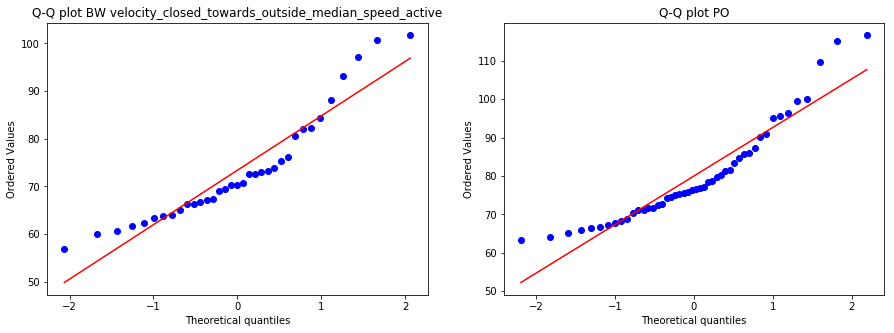

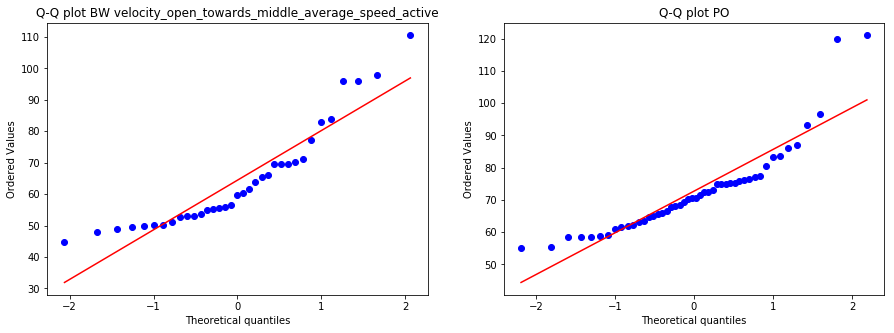

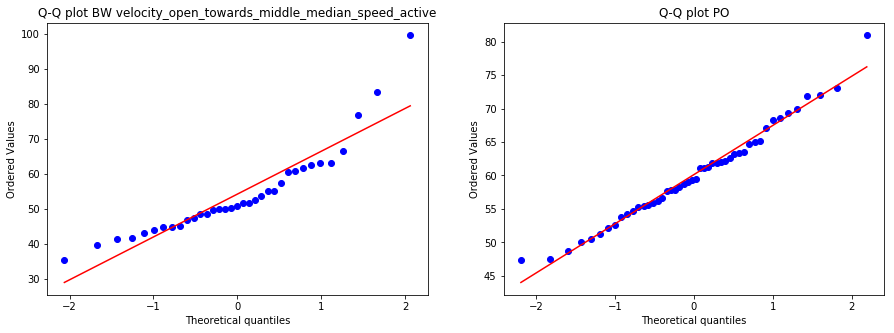

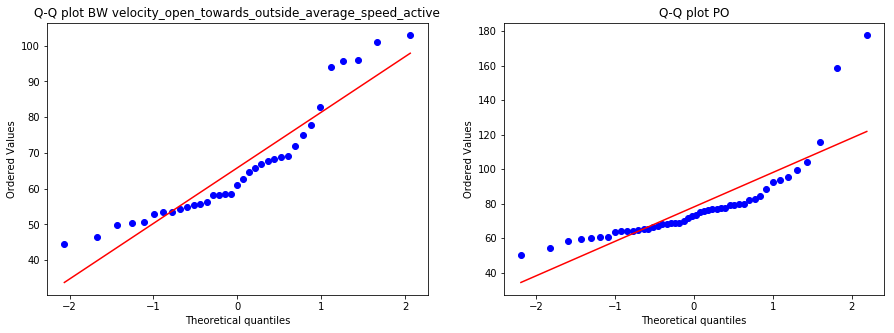

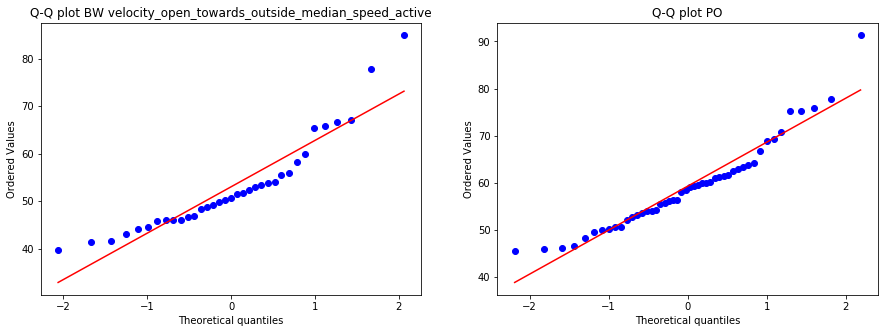

In [229]:
# All Q-Q plots

for feature in final_features:

    plt.subplots(1, 2, figsize=(15, 5))

    plt.subplot(1, 2, 1)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW'), feature], dist="norm", plot=pylab)
    plt.title("Q-Q plot BW "+ feature)

    plt.subplot(1, 2, 2)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='PO'), feature], dist="norm", plot=pylab)
    plt.title("Q-Q plot PO")
             
    plt.show()

In [116]:
normality_p

[(2.742588662840717e-07, 0.12654823064804077),
 (0.5994850397109985, 0.6696019768714905),
 (0.7312443256378174, 0.5777376890182495),
 (0.0014683717163279653, 0.00010381147149018943),
 (0.00015643963706679642, 0.059735096991062164),
 (0.10567411780357361, 0.09280573576688766),
 (0.2897328734397888, 0.21329660713672638),
 (0.09734132885932922, 0.5152416825294495),
 (0.1710749864578247, 0.597891092300415),
 (0.4227966368198395, 0.4037451148033142),
 (0.0859859362244606, 0.1817632019519806),
 (0.7712780237197876, 0.7316817045211792),
 (0.7903890609741211, 0.9235390424728394),
 (0.2923506498336792, 0.9588120579719543),
 (0.30929920077323914, 0.019119126722216606),
 (0.0020309698302298784, 0.21614831686019897),
 (0.5579046010971069, 0.06265844404697418),
 (0.3574327826499939, 0.006831738166511059),
 (0.5267841815948486, 0.0005937484675087035),
 (0.04442670941352844, 0.004644644446671009),
 (0.3927597403526306, 0.27116599678993225),
 (0.24671944975852966, 0.9103150963783264),
 (0.476996362209

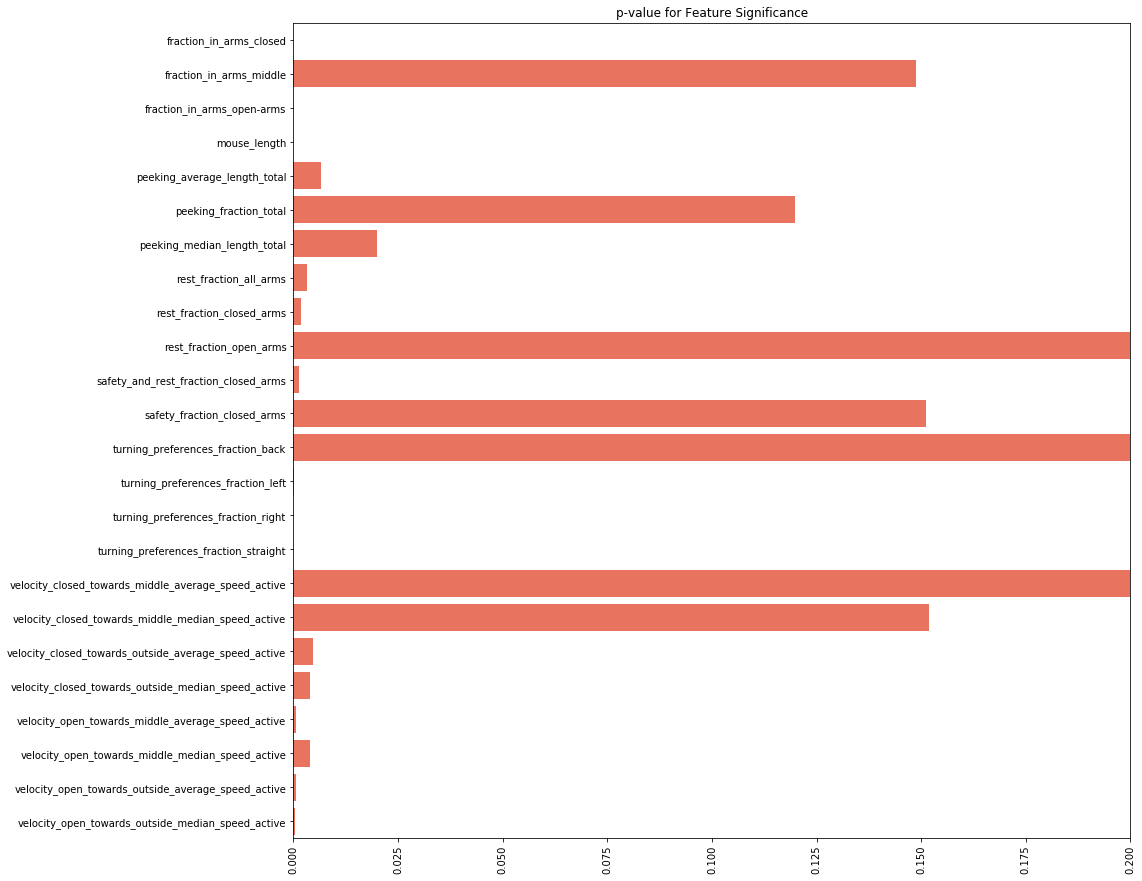

In [244]:
plt.figure(figsize=(15, 15))
plt.title("p-value for Feature Significance")
sns.barplot(x=stats_test_p, y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0,0.2)
plt.show()

## Example where Log transformation works

In [10]:
df_features_final= df_features.dropna()

In [24]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_fraction_total'])[1])
print(shapiro(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_fraction_total']))[1])

2.307562454006984e-06
0.1192852109670639


/Users/srinidhi/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


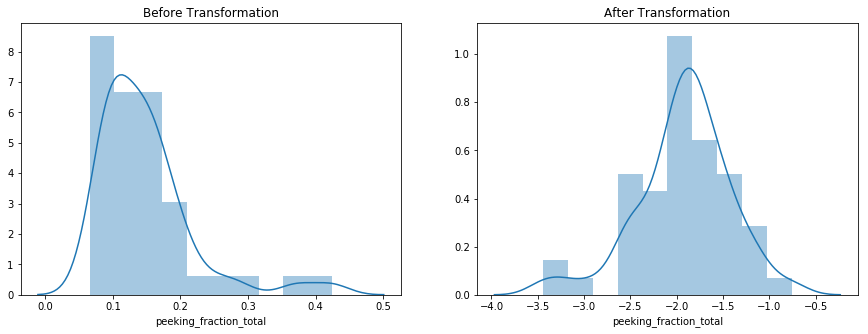

In [22]:
# Not Normal
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Before Transformation")
sns.distplot(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_fraction_total'], bins=10)

# Mostly Normal
plt.subplot(1, 2, 2)
plt.title("After Transformation")
sns.distplot(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'peeking_fraction_total']), bins=10)
plt.show()

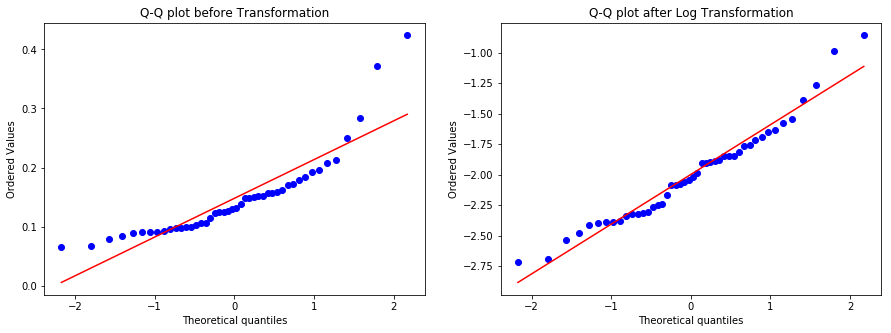

In [20]:
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
probplot(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_fraction_total'], dist="norm", plot=pylab)
plt.title("Q-Q plot before Transformation")

plt.subplot(1, 2, 2)
probplot(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_fraction_total']), dist="norm", plot=pylab)
plt.title("Q-Q plot after Log Transformation")

plt.show()

## Negative effect of outliers 
- Log transformation won't work as Shapiro wilk test is very sensitive

In [24]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active'])[1])
print(shapiro(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active']))[1])

9.785273505258374e-06
0.0027029169723391533


/Users/srinidhi/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


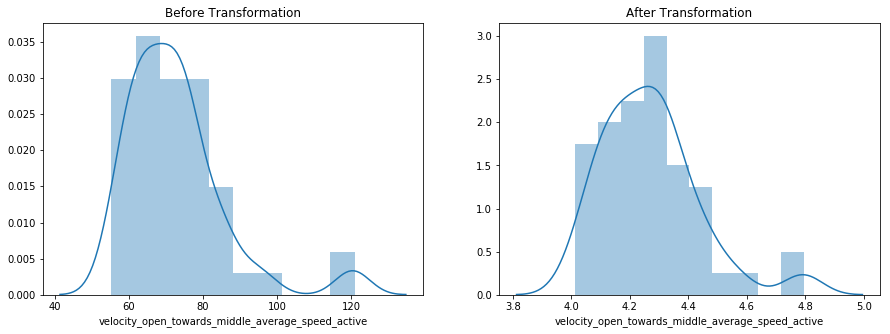

In [25]:
# Not Normal
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Before Transformation")
sns.distplot(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active'], bins=10)

# Mostly Normal
plt.subplot(1, 2, 2)
plt.title("After Transformation")
sns.distplot(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active']), bins=10)
plt.show()

#The RHS mostly looks normal except those outliers around 8.5

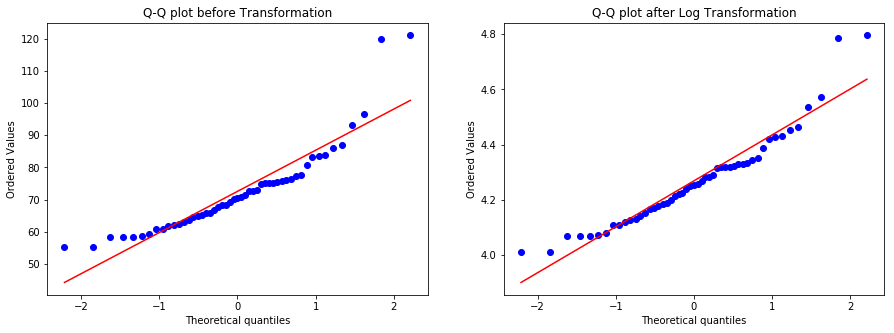

In [26]:
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
probplot(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active'], dist="norm", plot=pylab)
plt.title("Q-Q plot before Transformation")

plt.subplot(1, 2, 2)
probplot(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active']), dist="norm", plot=pylab)
plt.title("Q-Q plot after Log Transformation")

plt.show()

#Outliers clearly seen!


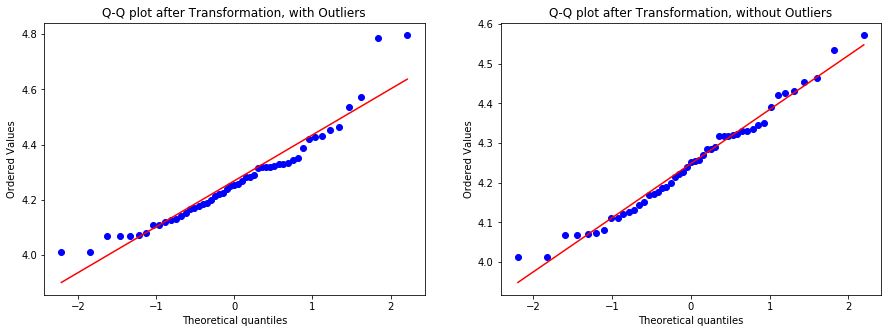

In [27]:
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
probplot(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active']), dist="norm", plot=pylab)
plt.title("Q-Q plot after Transformation, with Outliers")

plt.subplot(1, 2, 2)
probplot(np.log(sorted(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active'])[:-2]), dist="norm", plot=pylab)
plt.title("Q-Q plot after Transformation, without Outliers")

plt.show()

In [28]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active'])[1])
print(shapiro(np.log(sorted(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active'])[:-2]))[1])

#Outlier removal clearly helped!


9.785273505258374e-06
0.5203026533126831


In [35]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_outside_average_speed_active'])[1])
print(shapiro(np.log(sorted(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_outside_average_speed_active'])[:-2]))[1])

#Outlier removal clearly helped!


1.2264216309176845e-08
0.46230748295783997


## Other Issues

'fraction_in_arms_closed' - different distributions for BW and PO - can't do any transformation

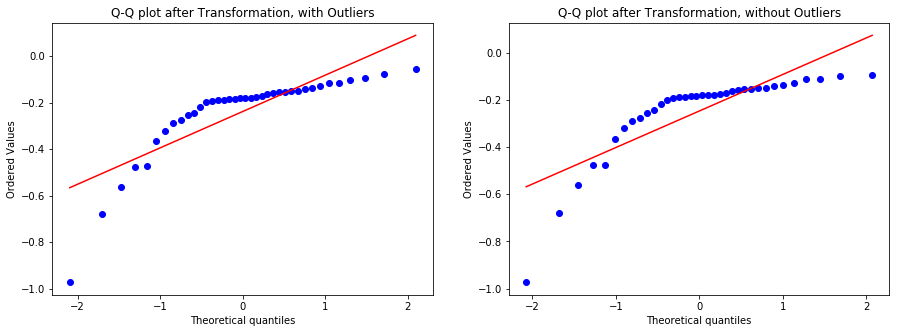

In [57]:
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
probplot(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'fraction_in_arms_closed']), dist="norm", plot=pylab)
plt.title("Q-Q plot after Transformation, with Outliers")

plt.subplot(1, 2, 2)
probplot(np.log(sorted(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'fraction_in_arms_closed'])[:-2]), dist="norm", plot=pylab)
plt.title("Q-Q plot after Transformation, without Outliers")

plt.show()

In [97]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [95]:
moore = sm.datasets.get_rdataset("Moore", "carData") # load
data = moore.data

In [99]:
data = data.rename(columns={"partner.status" : "partner_status"})
moore_lm = ols('conformity ~ C(fcategory, Sum)*C(partner_status, Sum)', data=data).fit()

In [101]:
data.head()

,partner_status,conformity,fcategory,fscore
0,low,8,low,37
1,low,4,high,57
2,low,8,high,65
3,low,7,low,20
4,low,10,low,36


In [103]:
table = sm.stats.anova_lm(moore_lm, typ=2) # Type 2 Anova DataFrame
print(table)

                                              sum_sq    df          F  \
C(fcategory, Sum)                          11.614700   2.0   0.276958   
C(partner_status, Sum)                    212.213778   1.0  10.120692   
C(fcategory, Sum):C(partner_status, Sum)  175.488928   2.0   4.184623   
Residual                                  817.763961  39.0        NaN   

                                            PR(>F)  
C(fcategory, Sum)                         0.759564  
C(partner_status, Sum)                    0.002874  
C(fcategory, Sum):C(partner_status, Sum)  0.022572  
Residual                                       NaN  


In [112]:
np.array(final_features)[stats_test_p<np.full(len(stats_test_p), 0.05)]

array(['fraction_in_arms_closed', 'fraction_in_arms_open-arms',
       'mouse_length', 'peeking_average_length_total',
       'peeking_median_length_total', 'rest_fraction_all_arms',
       'rest_fraction_closed_arms',
       'safety_and_rest_fraction_closed_arms',
       'turning_preferences_fraction_left',
       'turning_preferences_fraction_right',
       'turning_preferences_fraction_straight',
       'velocity_closed_towards_middle_median_speed',
       'velocity_closed_towards_outside_median_speed',
       'velocity_closed_towards_outside_median_speed_active',
       'velocity_open_towards_middle_median_speed_active',
       'velocity_open_towards_outside_median_speed',
       'velocity_open_towards_outside_median_speed_active'], dtype='<U51')

In [280]:
str('fraction_in_arms_open-arms')

'fraction_in_arms_open-arms'

# Two Factor Analysis

In [ ]:
# To determine if ANOVA conditions are satisfied

def anova_conditions(df, features, alpha_normal=0.05, alpha_significance=0.05):

    ''' significance(df_features, features, alpha_normal=0.05, alpha_significance=0.05)
    Input: DataFrame of aggregated mice features, features, alpha levels
    Output: Normality_results, Feature significance, p-values'''
    
    #Initiate empty lists for results
    normal_count = [] #Number of normal dist.
    normality_panova = [] #Tuple of normality test results
    std=[] #Levene's test

    for feature in features:
        
        sample1= df.loc[(df['mouse_details_strain']== 'BW') & (df['mouse_details_sex'] == 'M'), feature] 
        sample2= df.loc[(df['mouse_details_strain']== 'BW') & (df['mouse_details_sex'] == 'F'), feature] 
        sample3= df.loc[(df['mouse_details_strain']== 'PO') & (df['mouse_details_sex'] == 'M'), feature] 
        sample4= df.loc[(df['mouse_details_strain']== 'PO') & (df['mouse_details_sex'] == 'F'), feature] 
        
        #Do a Normality test and store p value
        norm1 = shapiro(sample1)[1]
        norm2 = shapiro(sample2)[1]
        norm3 = shapiro(sample3)[1]
        norm4 = shapiro(sample4)[1]
        
        norm_original = np.sum(np.array([norm1, norm2, norm3, norm4])>0.05)
        norm_log = np.sum(np.array([shapiro(np.log(sample1))[1], shapiro(np.log(sample2))[1], 
                                   shapiro(np.log(sample3))[1], shapiro(np.log(sample4))[1]])>0.05)
        norm_sq = np.sum(np.array([np.square(shapiro(sample1))[1], np.square(shapiro(sample2))[1], 
                                  np.square(shapiro(sample3))[1], np.square(shapiro(sample4)[1])])>0.05)
        
        normality_panova.append((norm_original, norm_log, norm_sq))
        std.append(levene(sample1, sample2, sample3, sample4)[1])
        
    return normal_anova, normality_panova, std#, significance, stats_test_p

In [258]:
normal_anova, normality_panova, std= anova_conditions(df_bwpo, features=final_features)

/Users/srinidhi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


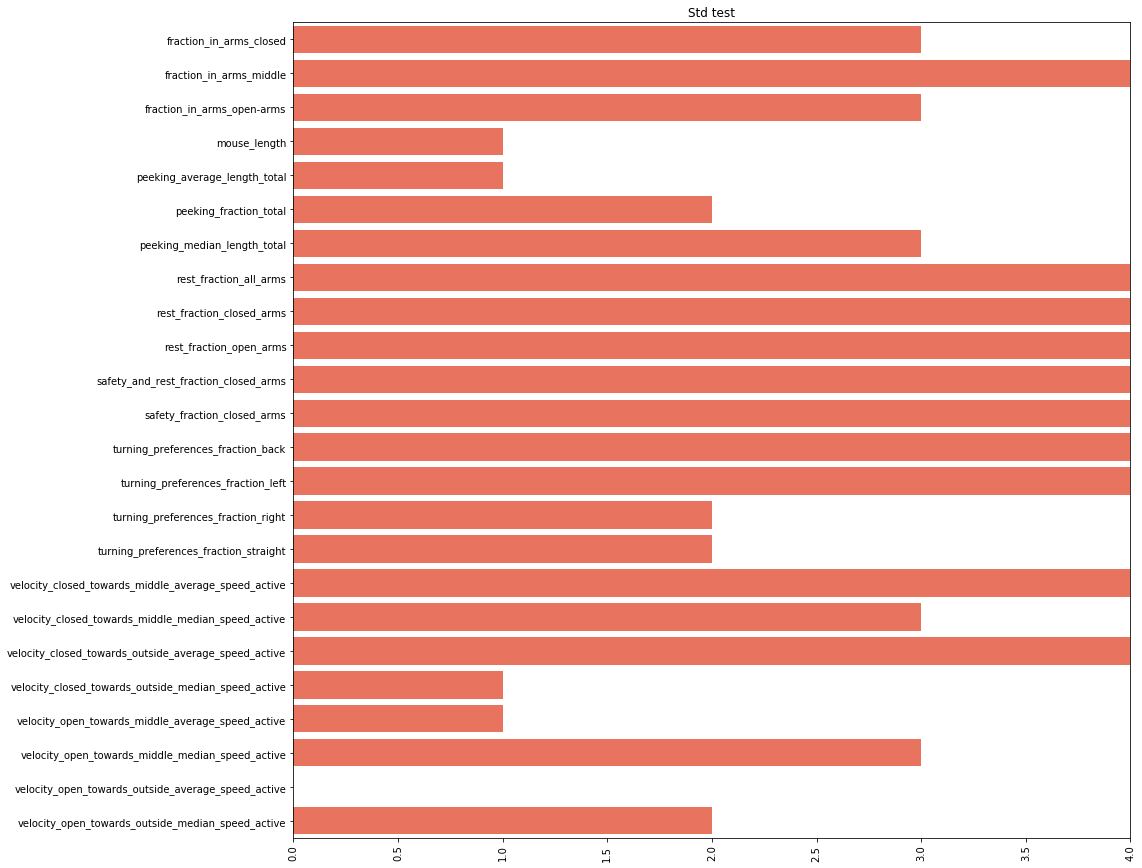

In [271]:
plt.figure(figsize=(15, 15))
plt.title("Std test")
sns.barplot(x=[norm[0] for norm in normality_panova], y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0, 4)
plt.show()

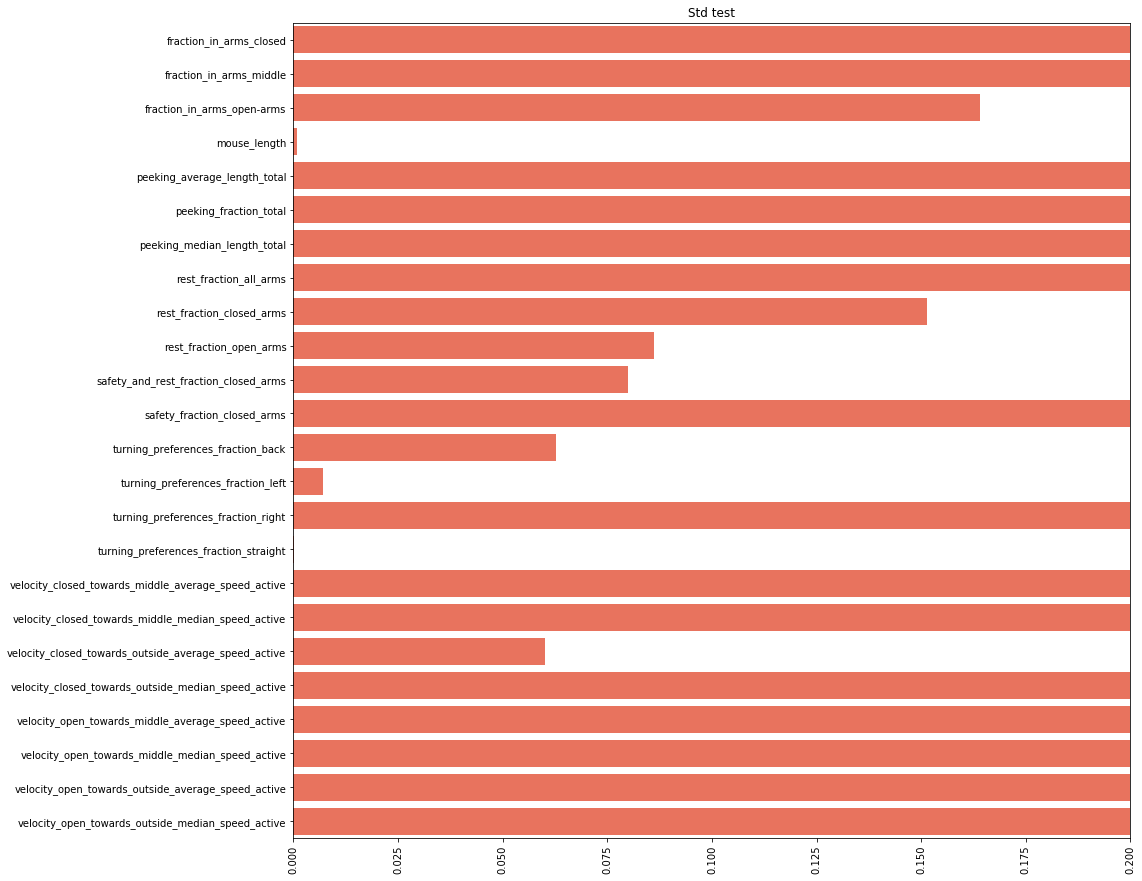

In [262]:
plt.figure(figsize=(15, 15))
plt.title("Std test")
sns.barplot(x=std, y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0,0.2)
plt.show()

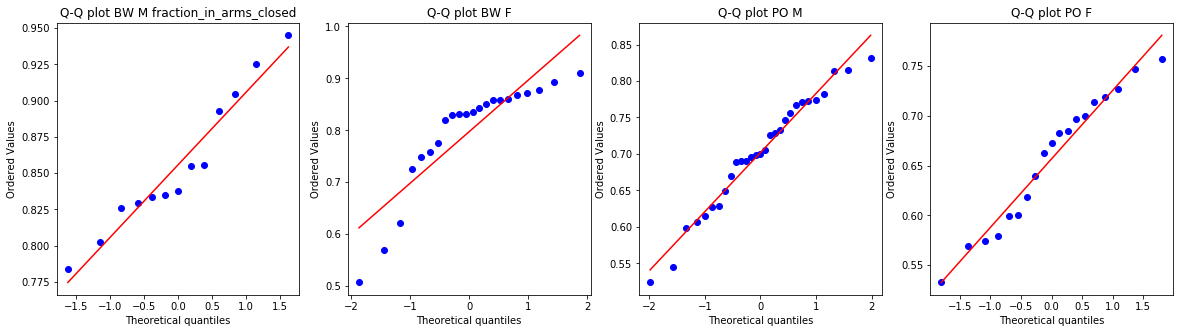

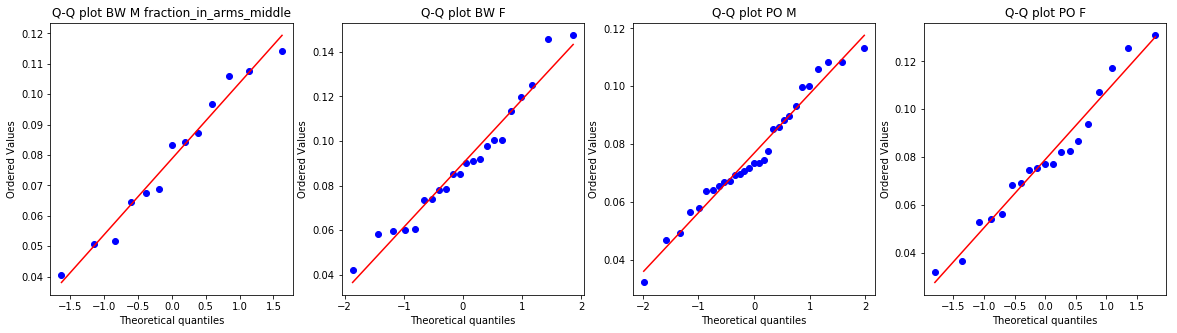

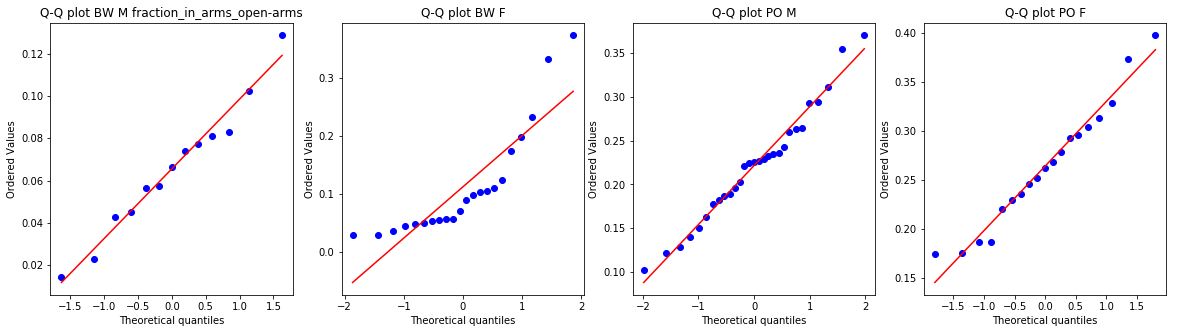

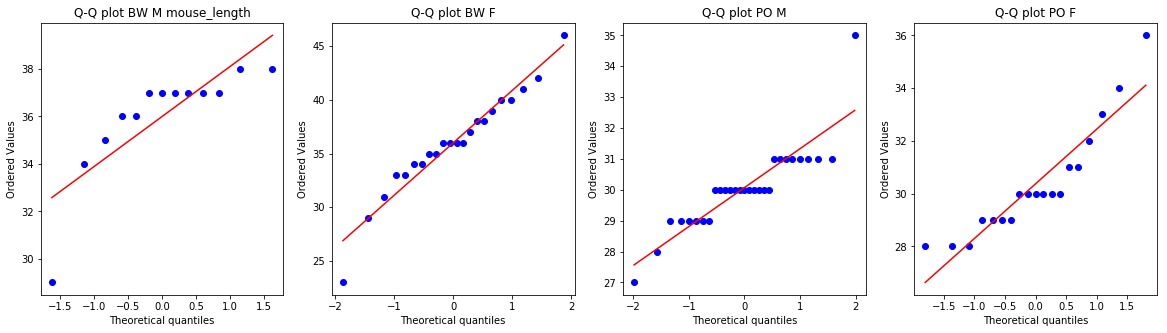

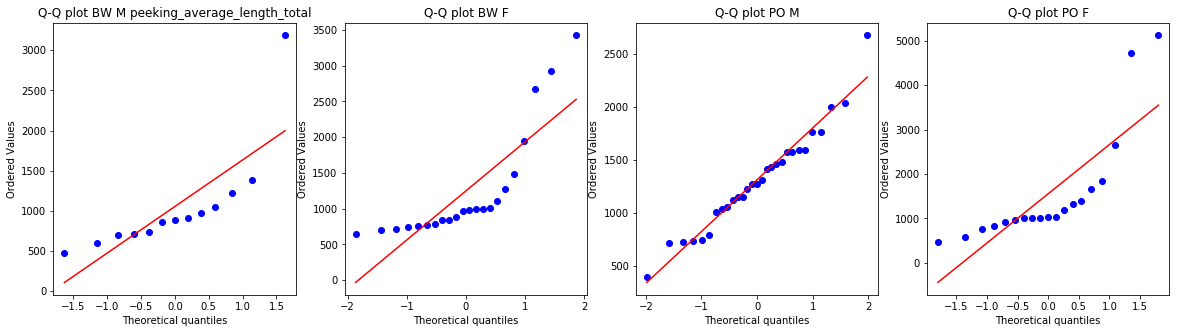

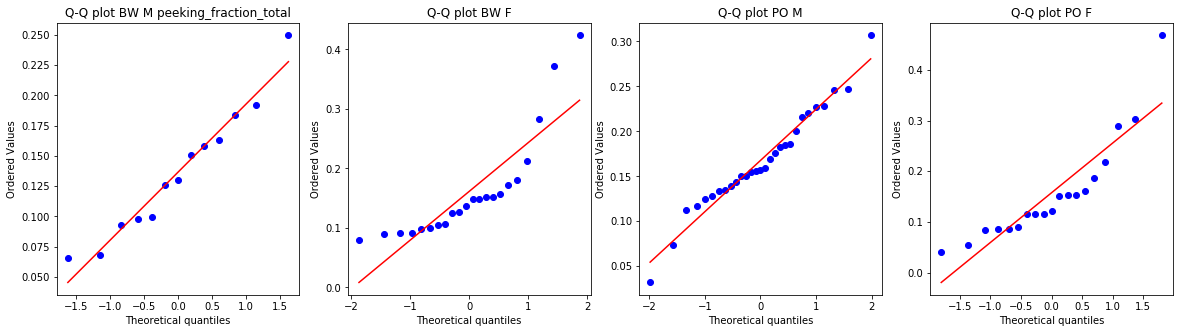

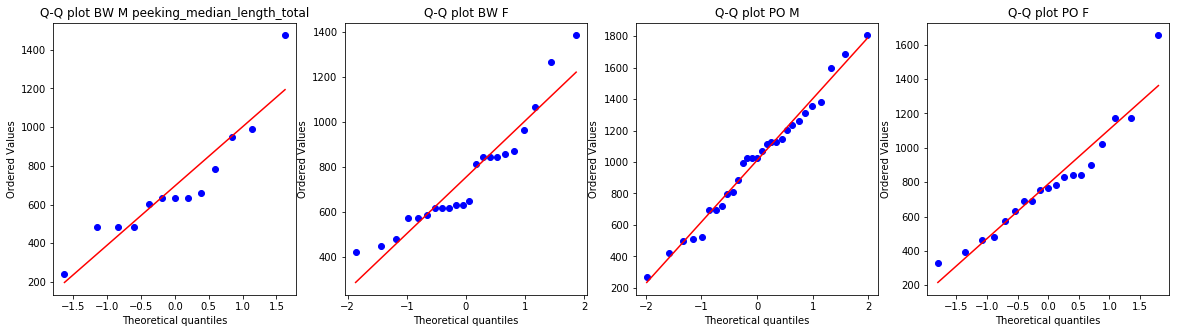

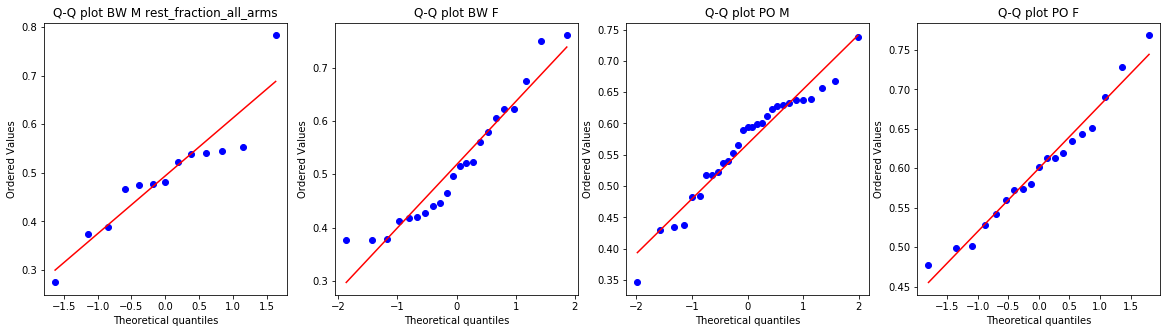

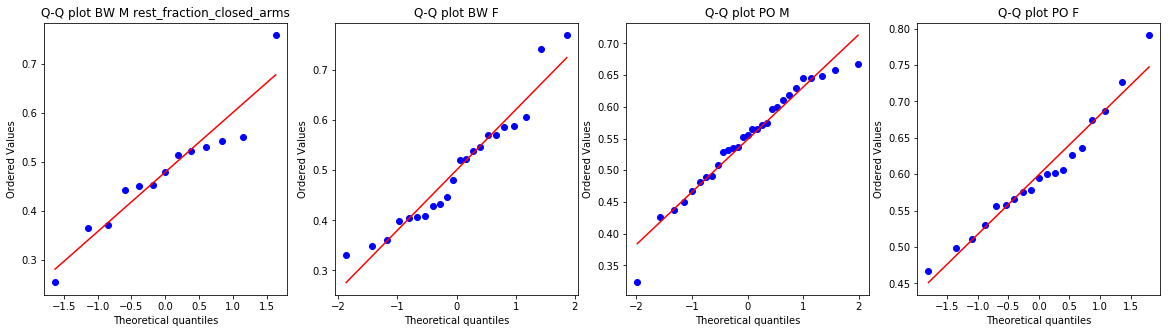

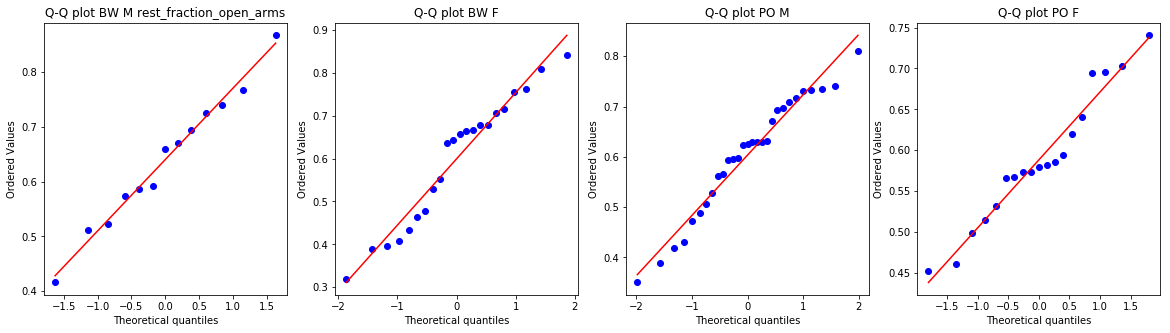

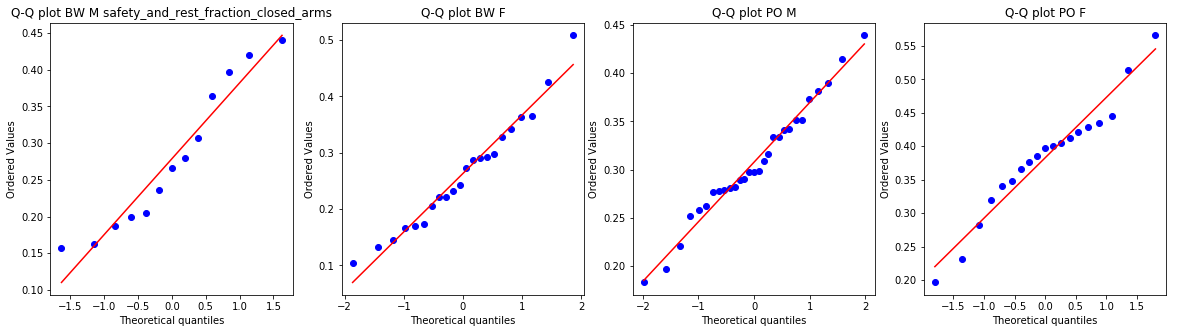

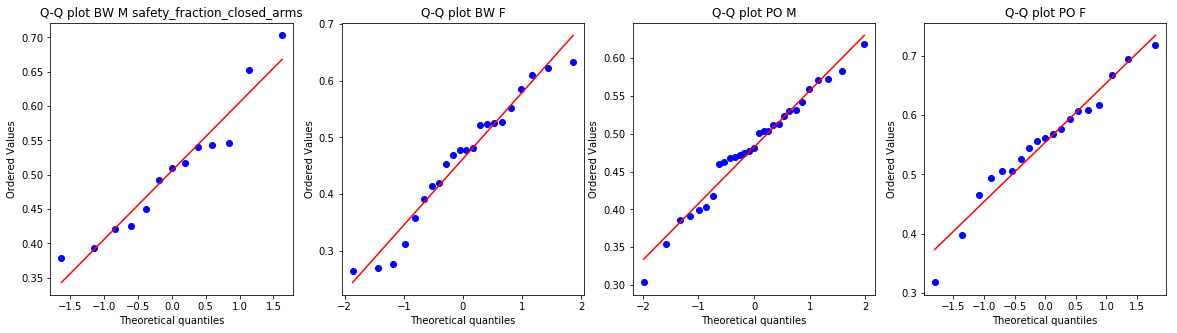

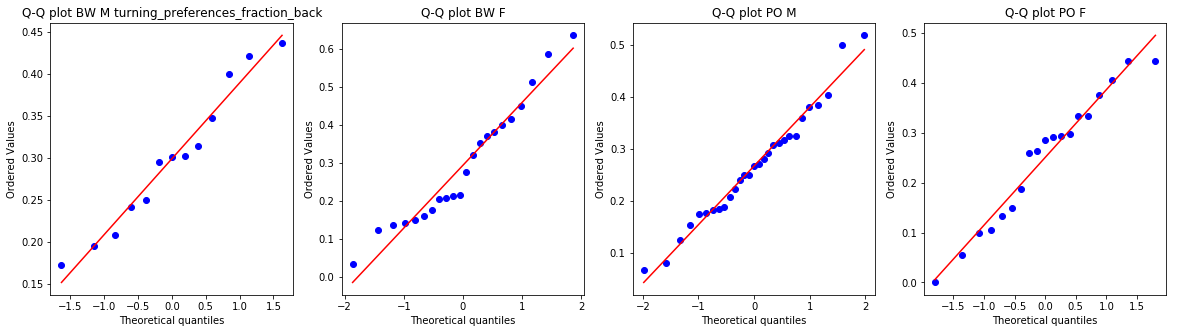

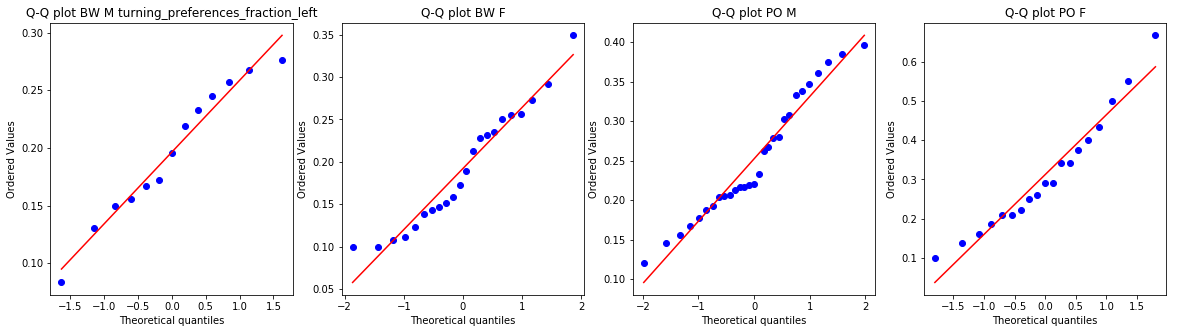

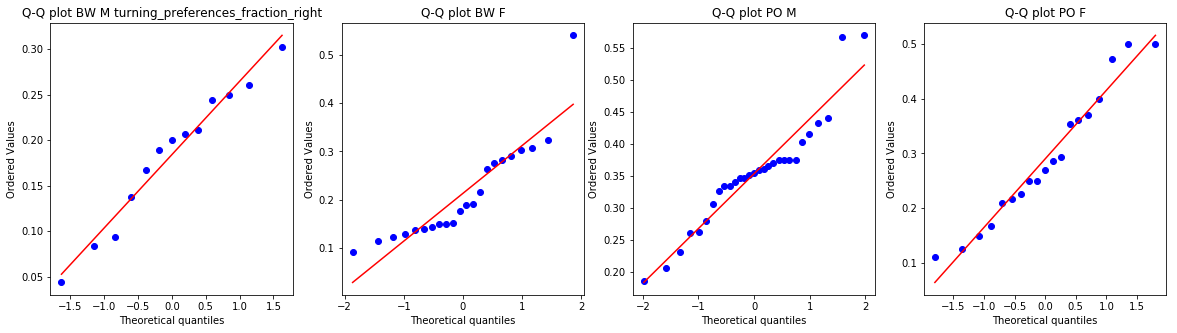

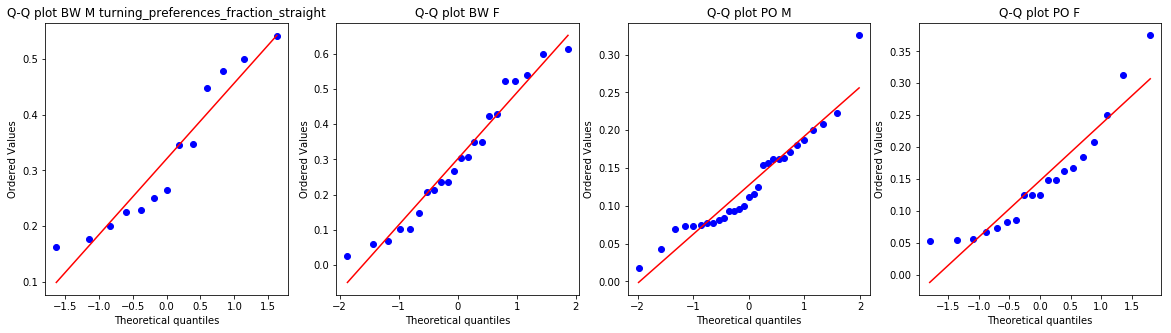

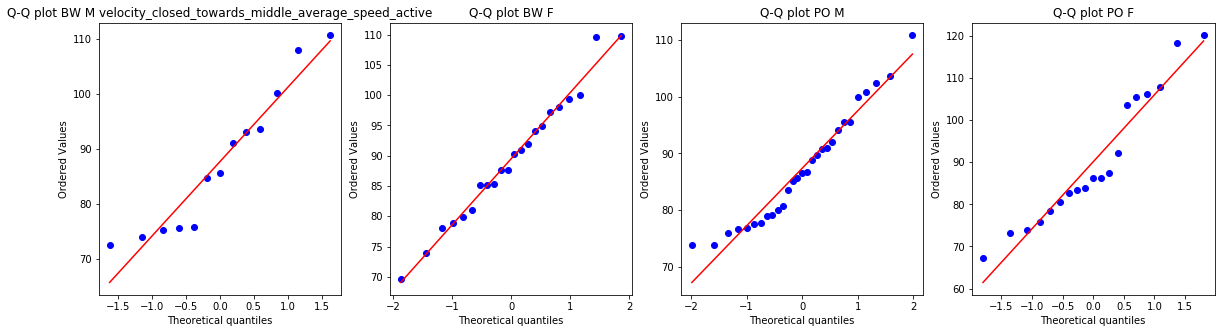

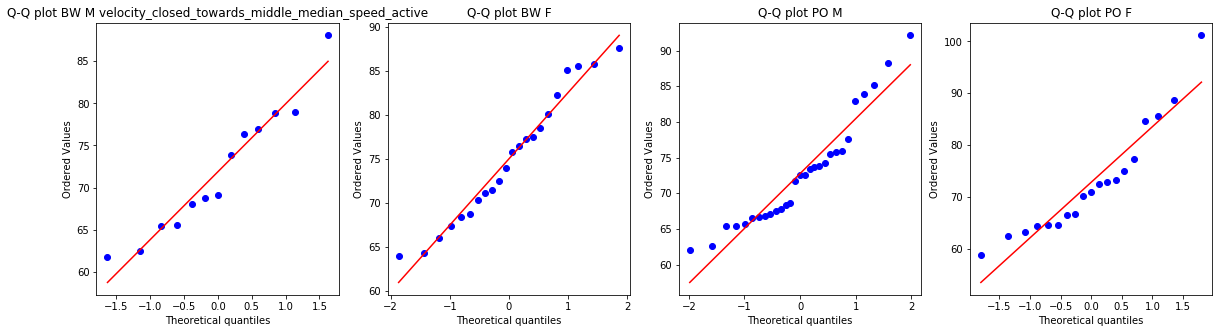

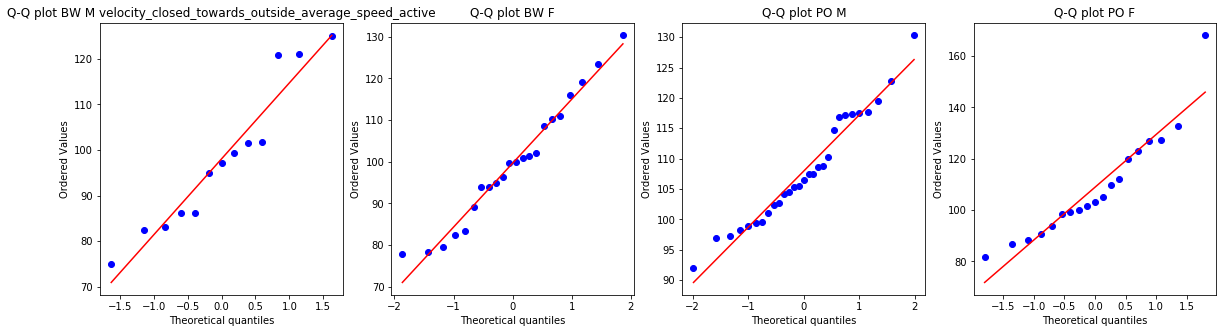

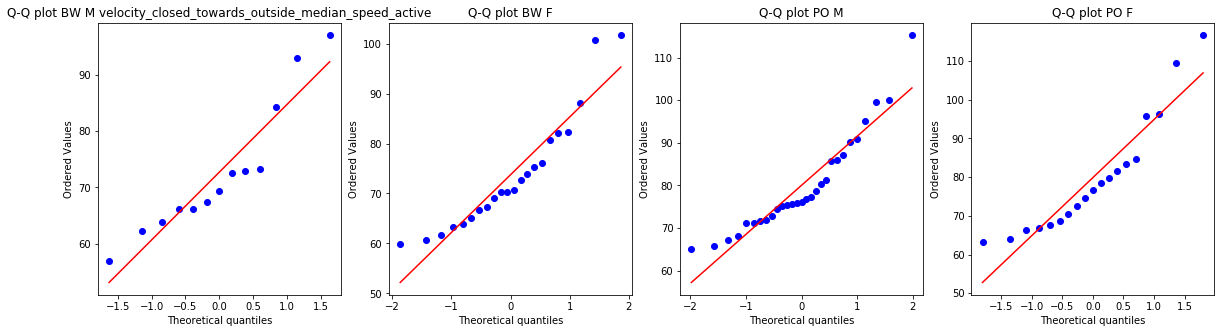

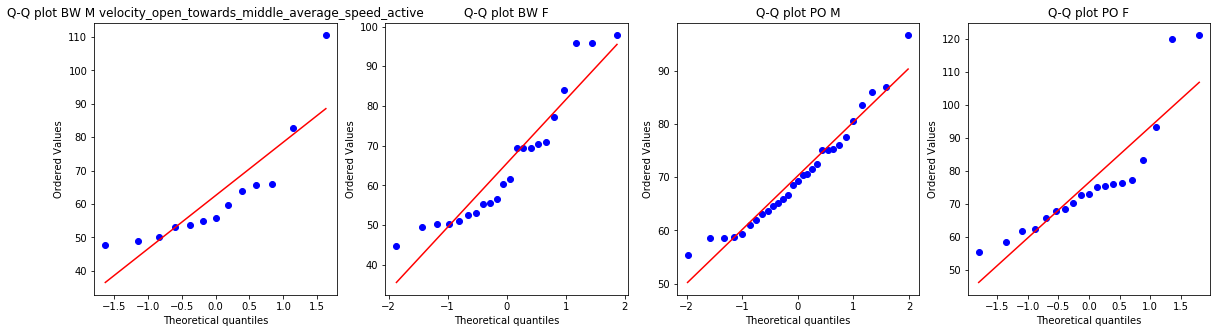

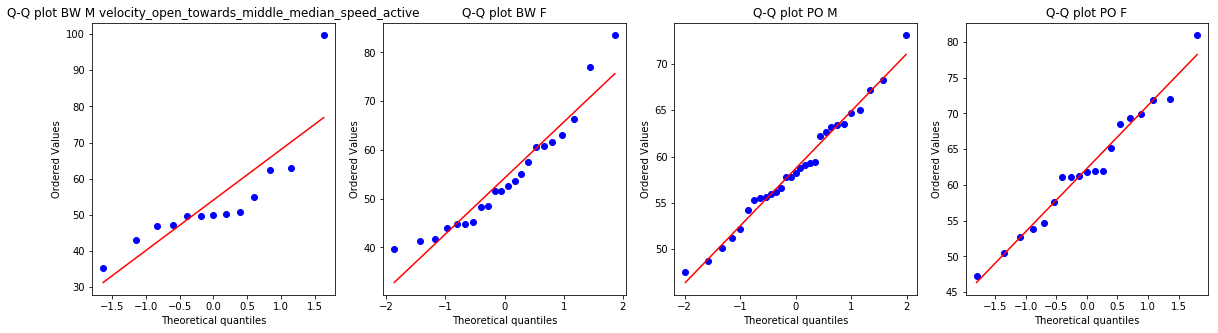

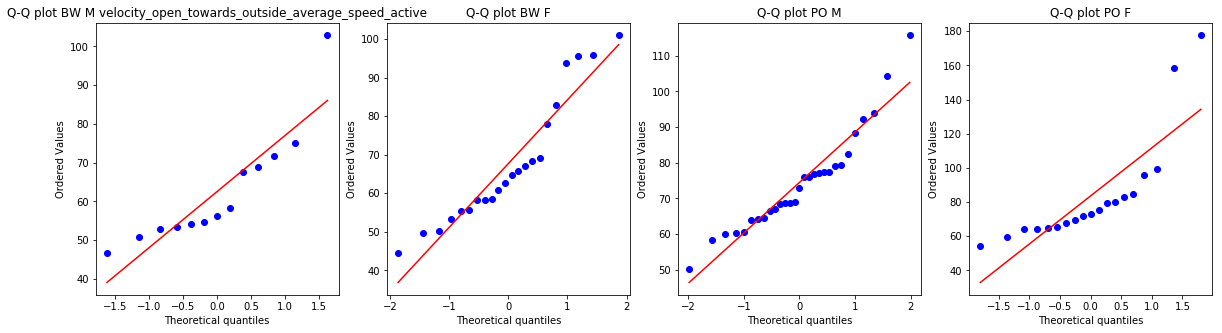

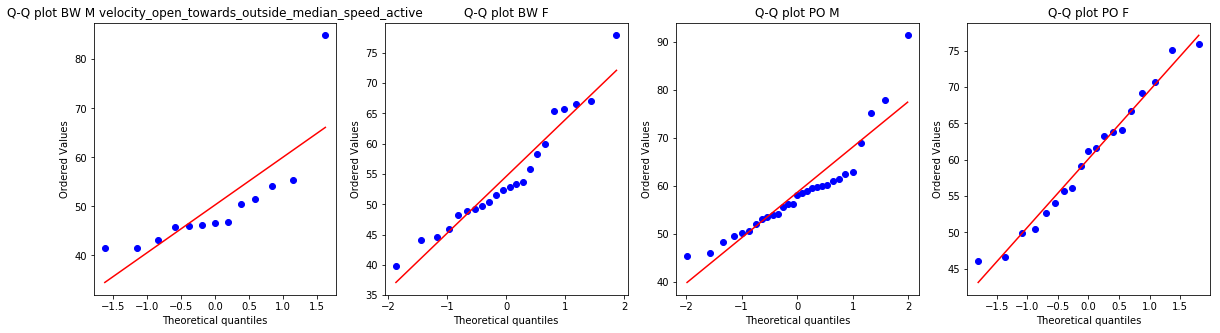

In [261]:
i=0
for feature in final_features:

    plt.subplots(1, 4, figsize=(20, 5))

    plt.subplot(1, 4, 1)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') &
                                    (df_bwpo['mouse_details_sex']=='M'), feature], dist="norm", plot=pylab)
    plt.title("Q-Q plot BW M "+ feature)

    plt.subplot(1, 4, 2)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') &
                                    (df_bwpo['mouse_details_sex']=='F'), feature], dist="norm", plot=pylab)
    plt.title("Q-Q plot BW F")

    plt.subplot(1, 4, 3)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='PO') &
                                    (df_bwpo['mouse_details_sex']=='M'), feature], dist="norm", plot=pylab)
    plt.title("Q-Q plot PO M")

    plt.subplot(1, 4, 4)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='PO') &
                                    (df_bwpo['mouse_details_sex']=='F'), feature], dist="norm", plot=pylab)
    plt.title("Q-Q plot PO F")
             
    plt.show()

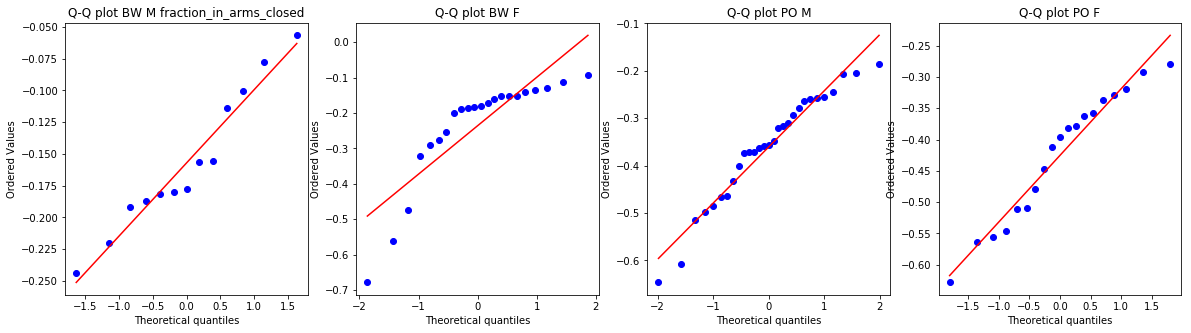

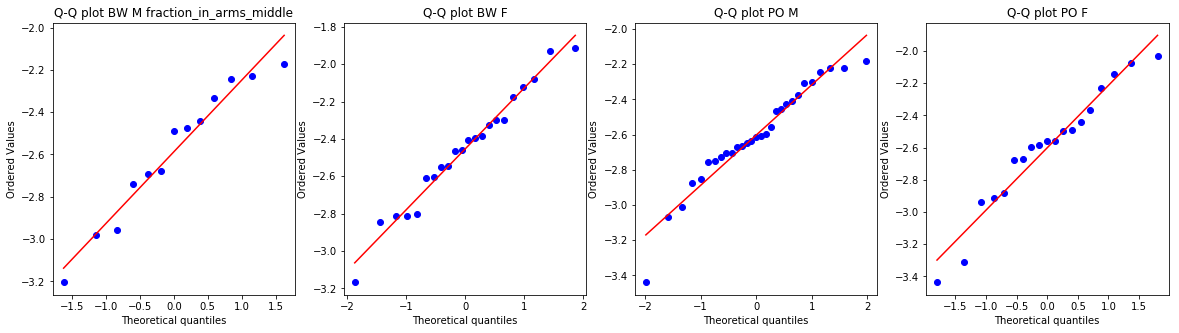

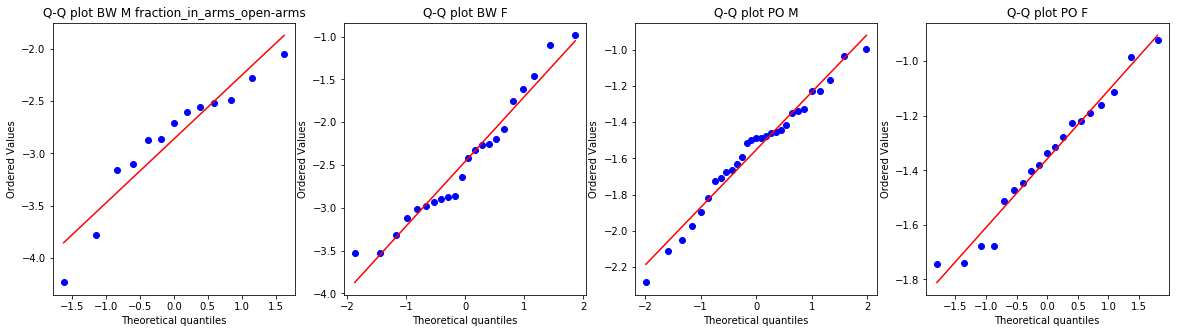

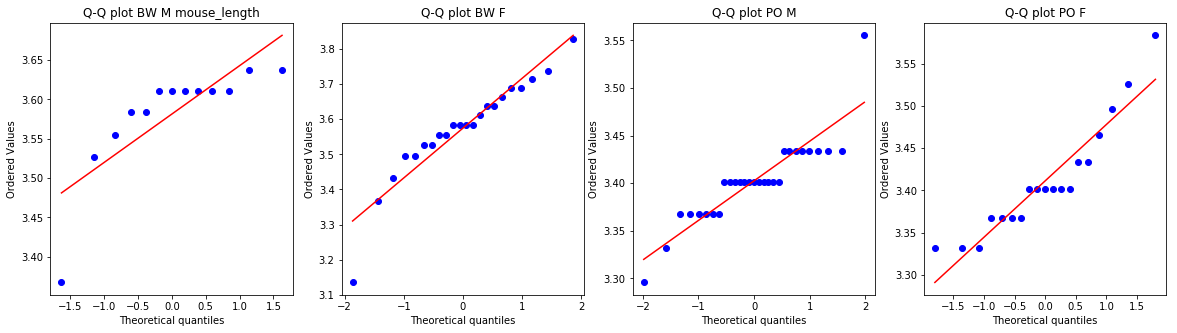

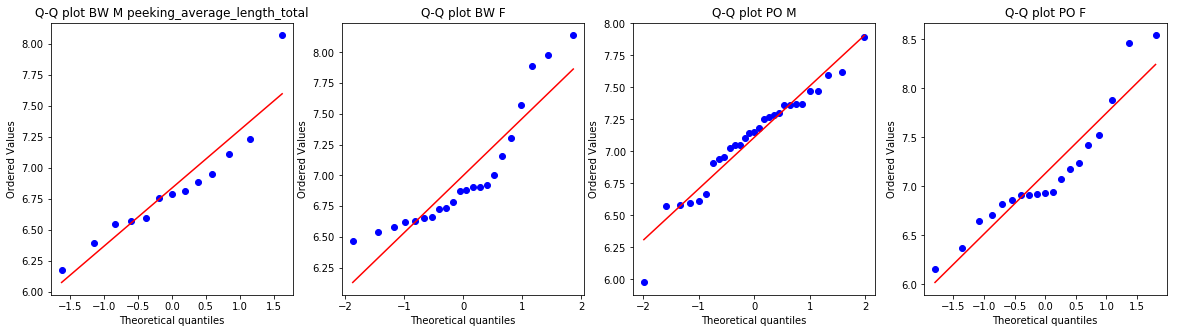

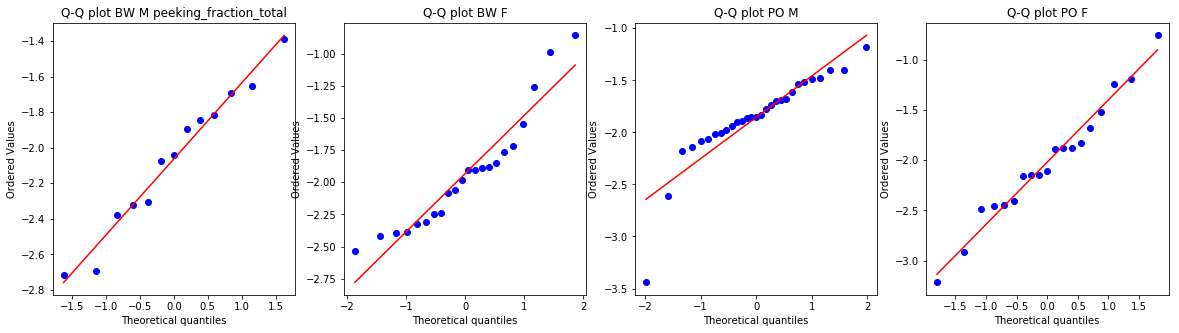

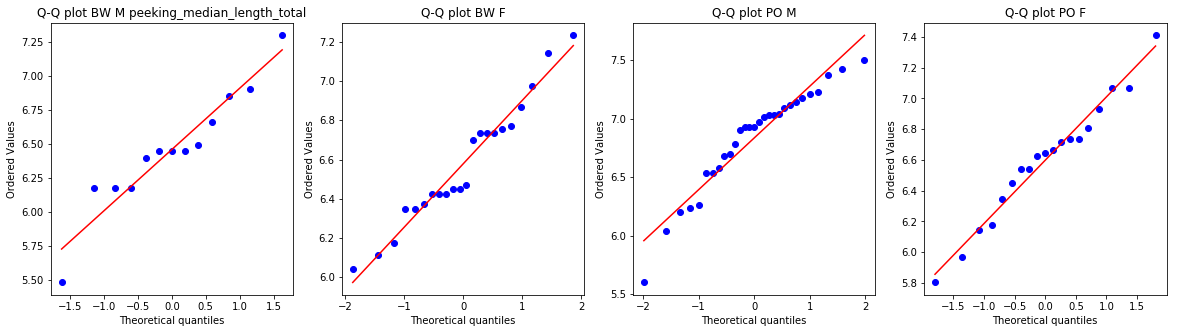

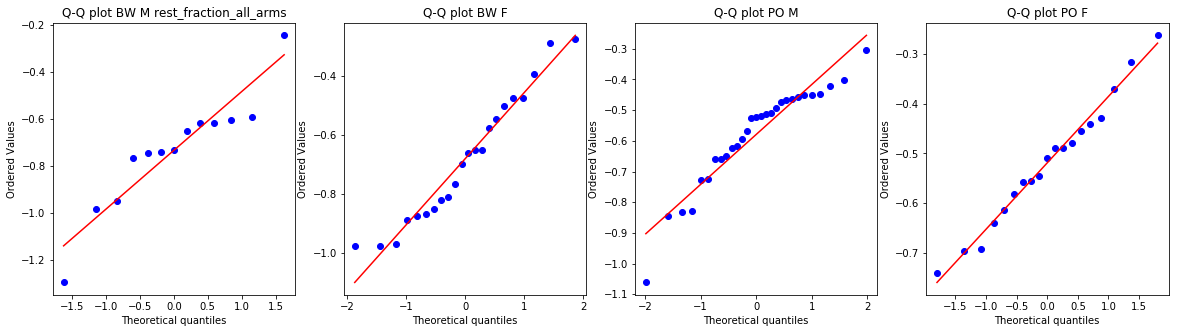

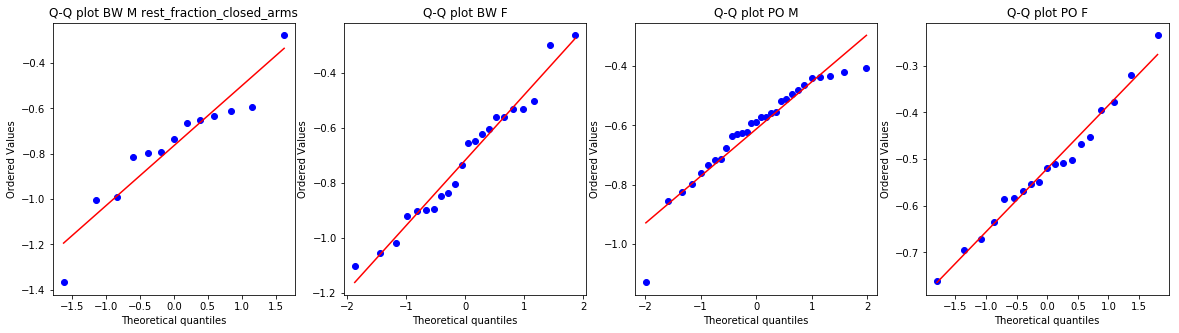

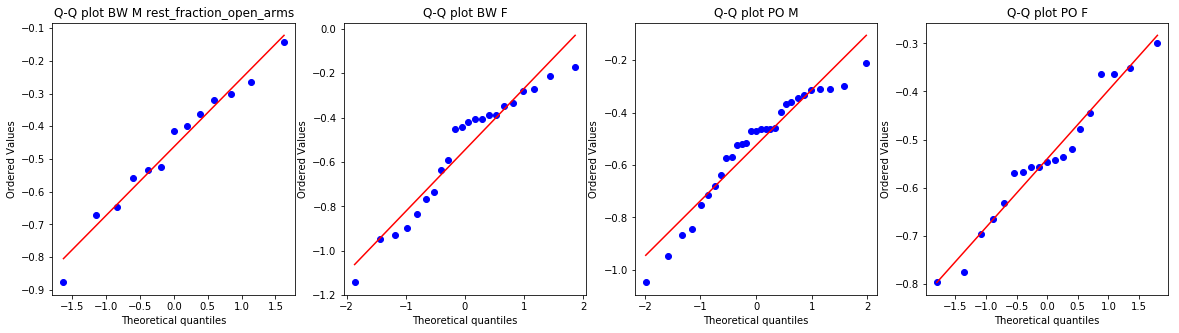

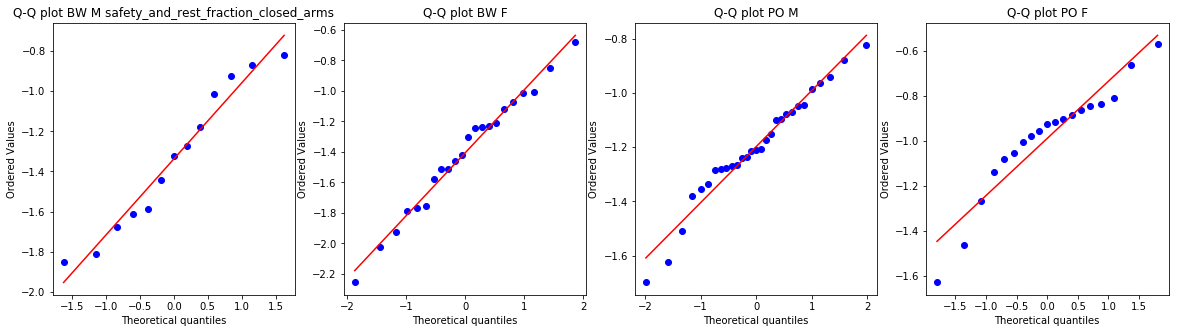

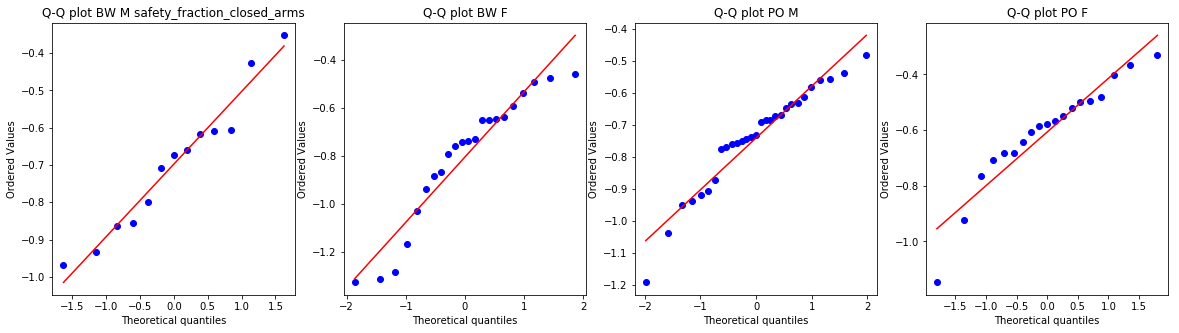

/Users/srinidhi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/Users/srinidhi/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:2320: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


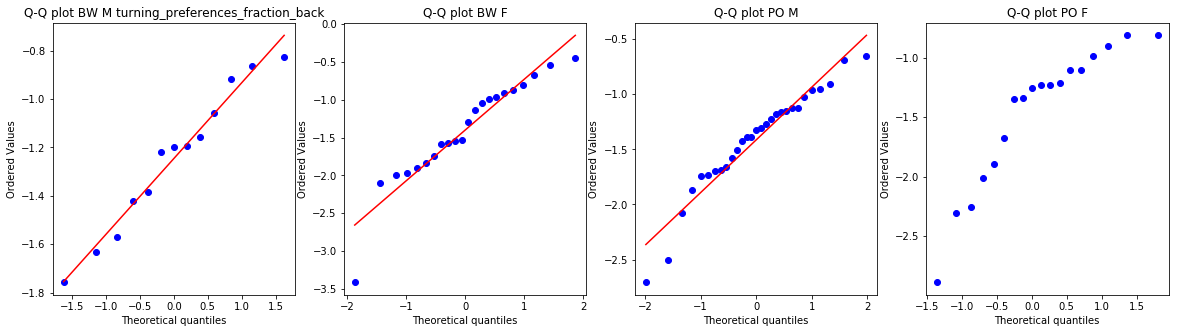

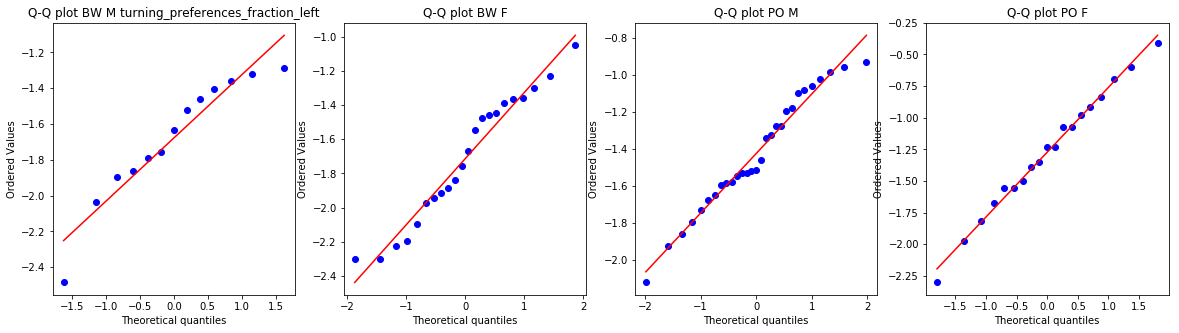

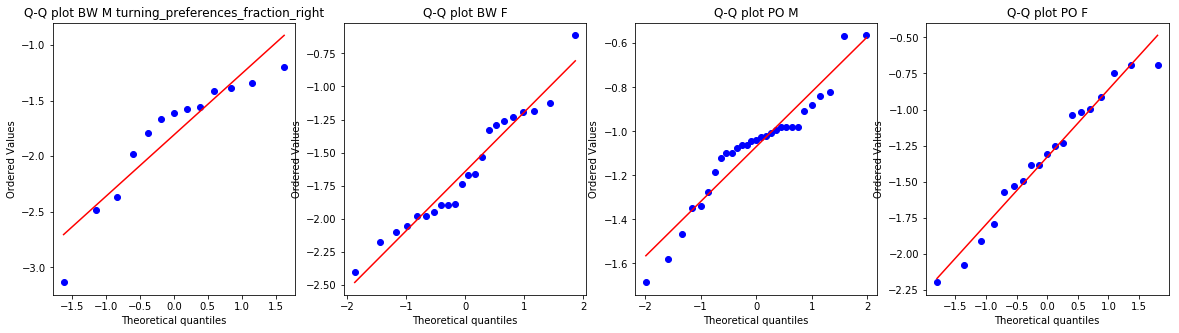

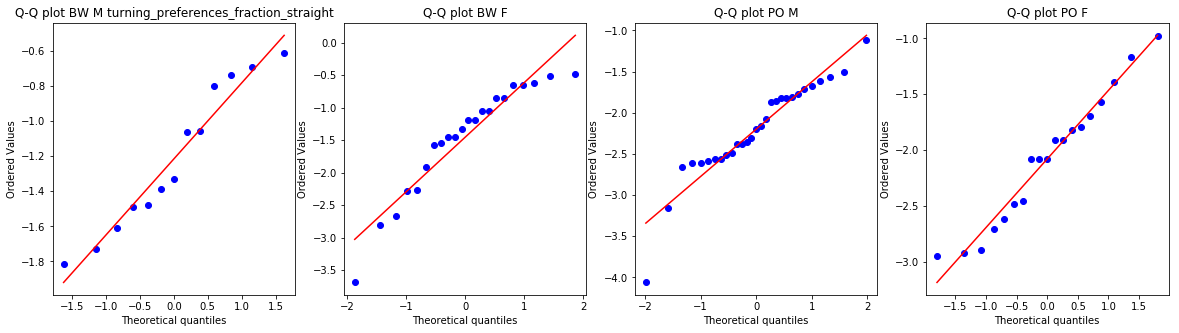

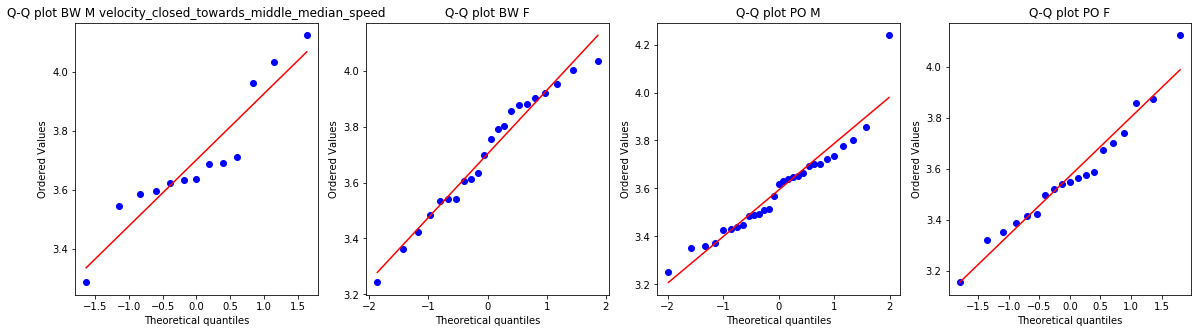

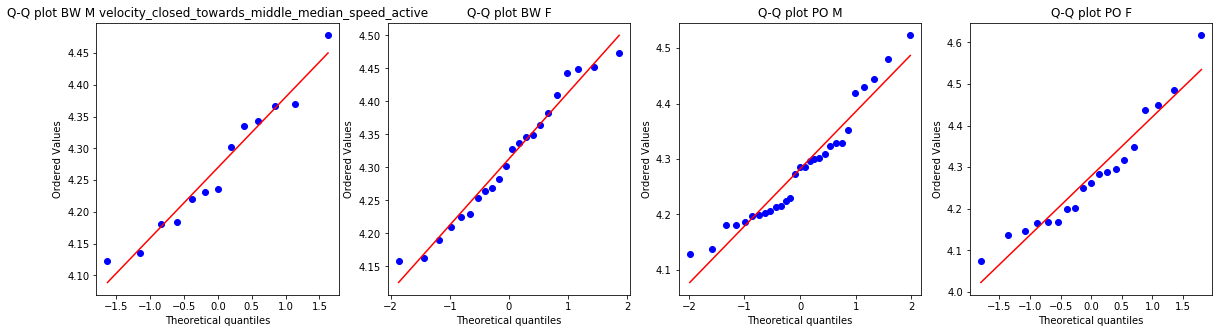

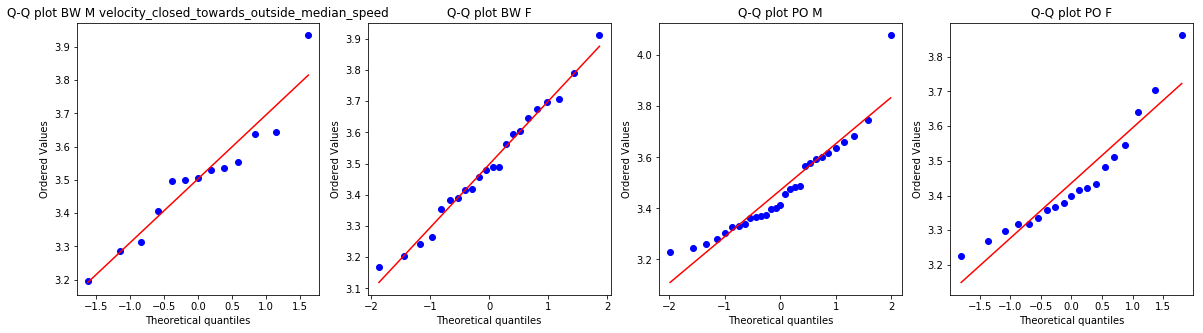

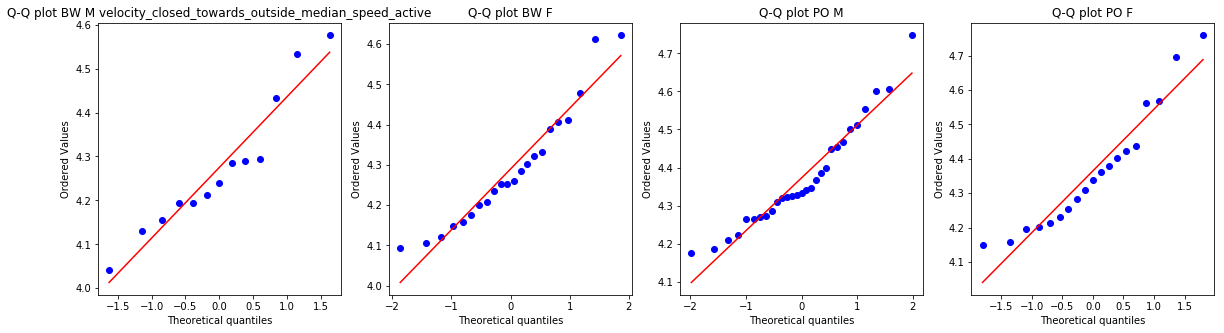

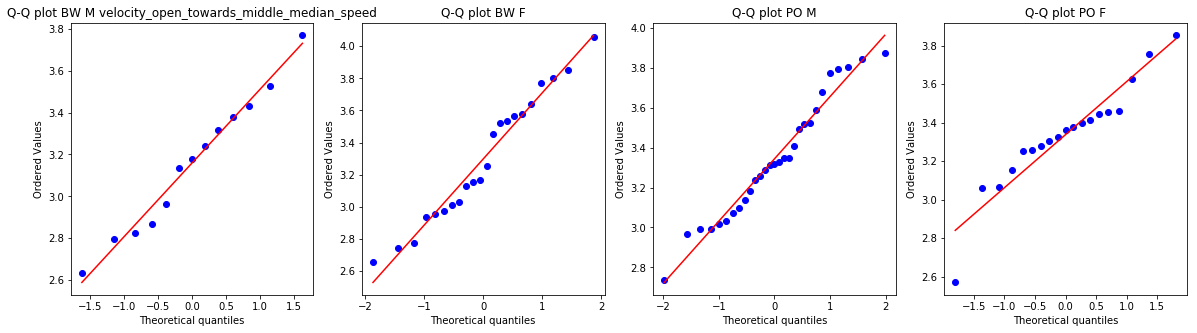

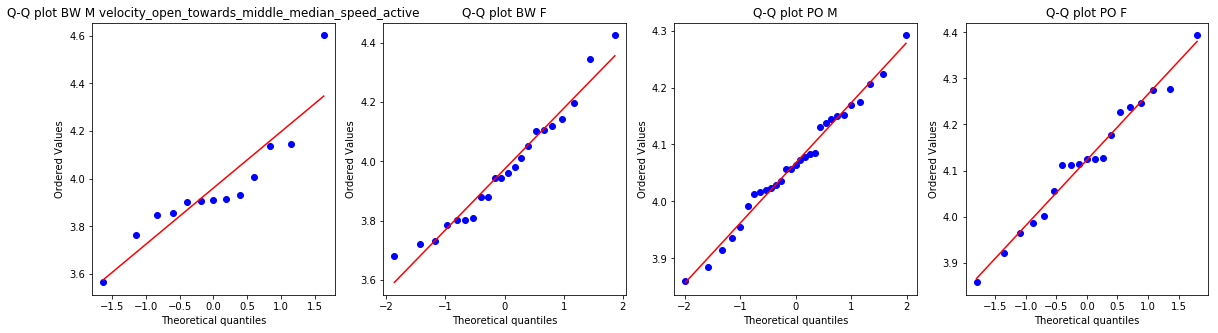

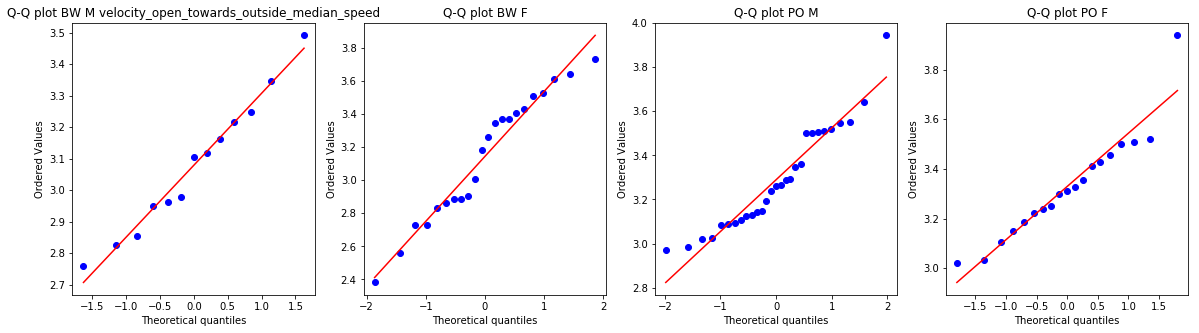

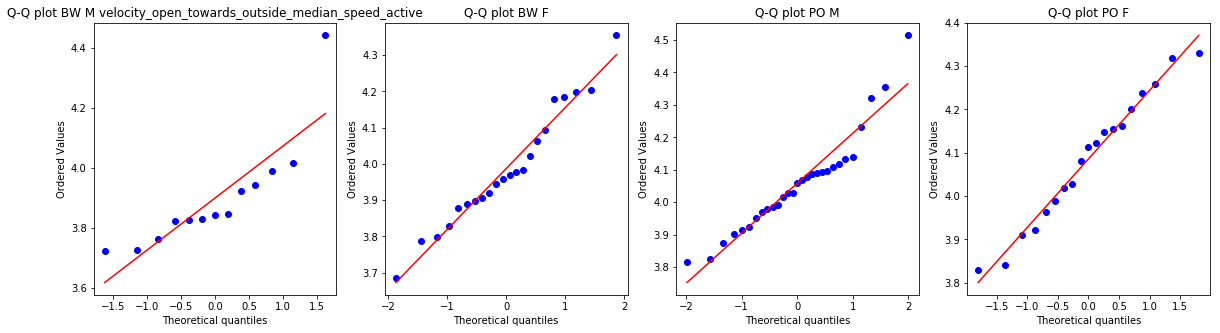

In [178]:
i=0
for feature in final_features:

    plt.subplots(1, 4, figsize=(20, 5))

    plt.subplot(1, 4, 1)
    probplot(np.log(df_features_final.loc[(df_features_final['mouse_details_strain']=='BW') &
                                    (df_features_final['mouse_details_sex']=='M'), feature]), dist="norm", plot=pylab)
    plt.title("Q-Q plot BW M "+ feature)

    plt.subplot(1, 4, 2)
    probplot(np.log(df_features_final.loc[(df_features_final['mouse_details_strain']=='BW') &
                                    (df_features_final['mouse_details_sex']=='F'), feature]), dist="norm", plot=pylab)
    plt.title("Q-Q plot BW F")

    plt.subplot(1, 4, 3)
    probplot(np.log(df_features_final.loc[(df_features_final['mouse_details_strain']=='PO') &
                                    (df_features_final['mouse_details_sex']=='M'), feature]), dist="norm", plot=pylab)
    plt.title("Q-Q plot PO M")

    plt.subplot(1, 4, 4)
    probplot(np.log(df_features_final.loc[(df_features_final['mouse_details_strain']=='PO') &
                                    (df_features_final['mouse_details_sex']=='F'), feature]), dist="norm", plot=pylab)
    plt.title("Q-Q plot PO F")
             
    plt.show()

In [289]:
# ANOVA

def anova(df, features, alpha_significance=0.05):

    ''' significance(df_features, features, alpha_normal=0.05, alpha_significance=0.05)
    Input: DataFrame of aggregated mice features, features, alpha levels
    Output: Normality_results, Feature significance, p-values'''
    
    #Initiate empty lists for results

    significance_species= []
    significance_sex= []
    significance_species_sex= []
    
    for feature in features:
        
        data = df_bwpo[['mouse_details_sex', 'mouse_details_strain', feature]]
        model = ols(feature+' ~ C(mouse_details_strain, Sum)*C(mouse_details_sex, Sum)', data=data).fit()
        table = sm.stats.anova_lm(model, typ=2) # Type 2 Anova DataFrame

        significance_species.append(table['PR(>F)'][0])
        significance_sex.append(table['PR(>F)'][1])
        significance_species_sex.append(table['PR(>F)'][2])
        
    return significance_species, significance_sex, significance_species_sex#, significance, stats_test_p

In [290]:
anova_species, anova_sex, anova_species_sex = anova(df_bwpo, final_features)

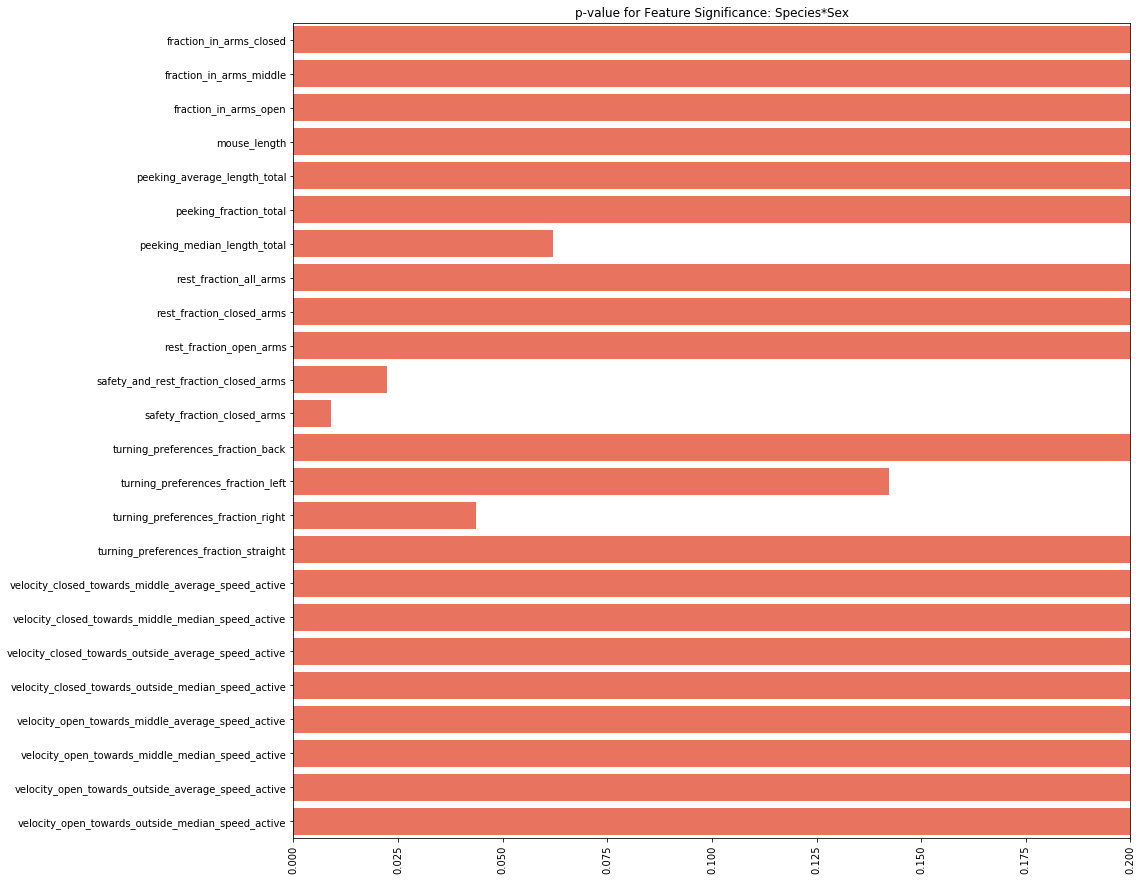

In [302]:
plt.figure(figsize=(15, 15))
plt.title("p-value for Feature Significance: Species*Sex")
sns.barplot(x=anova_species_sex, y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0, 0.2)
plt.show()

In [307]:
df_bwpo.groupby(['mouse_details_strain', 'mouse_details_sex'])['turning_preferences_fraction_straight'].mean()

mouse_details_strain  mouse_details_sex
BW                    F                    0.301335
                      M                    0.320731
PO                    F                    0.147437
                      M                    0.127362
Name: turning_preferences_fraction_straight, dtype: float64